# Orbitrap data treatment 
    Inputs: a series of .isox files and a sequence.csv file, for a series of Vanquish injections
    Outputs: an excel file compiling all the results from each step of calculation:
        - block averages
        - bracketed deltas for each sample and a statistical summary
        - statistical summary of internationally referenced deltas

## 1. Data and sequence import and pretreatment  
#### a. Import .isox data and sequence file from pathdata  
#### b. Selection of injection plateau and filtering of outlying scans  
        i.Filter using t_start and t_end  
        ii. Filter using TIC thresholds lower_threshold and upper_threshold relative to median TIC  
        iii. Filter scans by TICxIT - remove outlying fraction_to_discard  
        iv. Remove data for isotoplogues detected in only a few scans using isotopologue_threshold  
 #### c. Verification of data quality  
        i. Check variability in Orbtirap analyser temperature  
        ii. Check peak resolution range for weakest isotopologues  
        iii. Check the time period extracted for outlying blocks
## 2. Block verification and filtering
#### a. Extract block average ratios  
#### b. Check for outlying behaviour between blocks
        e.g. trends in TIC or isotopes, check for empty vials (no signal)
#### c. Check for outlying behaviour within blocks
        e.g. TIC jumps that affect d18O values
#### d. Filtering of blocks
        Select blocks to remove, or use simple filters
## 3. Calculation of delta values
#### a. Bracketing
        Error propagation: maximum between sem of injections and propogated error value
#### b. Correction to international scale using known value of internal standard
        Input ref_filename

## 4. Plots of final results
        Averages for small deltas and D17O

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# INPUTS

pathdata = 'data'
seq_filename = 'sequence.csv'
ref_filename = 'references_sulphate.xlsx'

pathresults = 'results_'+current_date_string
output_file = 'results_'+current_date_string+'.xlsx'

# create folder for sorted output
def create_folder(directory, folder_name):
    # Combine the directory path and folder name
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder doesn't already exist
    if not os.path.exists(folder_path):
        try:
            # Create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created successfully at '{directory}'.")
        except OSError as e:
            print(f"Error creating folder: {e}")
    else:
        print(f"Folder '{folder_name}' already exists at '{directory}'.")

create_folder('',pathresults)

Folder 'results_2025-02-08' created successfully at ''.


## 1. Data and sequence import and pretreatment  
#### a.  Import of .isox data and sequence file from pathdata

In [2]:
# Import sequence file

seq = pd.read_csv(os.path.join(pathdata,seq_filename),header=1)
seq = seq.loc[:,[col for col in seq.columns if col not in ['Process Method','Calibration File','Comment']]]

# fill in compound and experiment column based on method file name
seq['Expt']=''
seq['Compound']=''
for i in seq.index:
    if 'NO3' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Compound'] = 'NO3'
    elif 'SO4' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Compound'] = 'SO4'
    elif 'SO3' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Compound'] = 'SO3'
    if ('noM0' in seq.loc[i,'Instrument Method']) or ('nom0' in seq.loc[i,'Instrument Method']):
        seq.loc[i,'Expt']='noM0'
    elif 'Full_spectrum' in seq.loc[i,'Instrument Method']:
        seq.loc[i,'Expt']='Full spectrum'
        seq.loc[i,'Compound']=''
    else:
        seq.loc[i,'Expt']='M0'
        
# display
seq.groupby('Position').first().sort_values('Sample ID')

Sample Type   File Name  Sample ID  \
Position                                      
B:F9         Unknown  250203_001          1   
B:D7         Unknown  250203_009          9   
B:E6         Unknown  250203_013         13   
B:E2         Unknown  250203_015         15   
B:D1         Unknown  250203_017         17   
B:E8         Unknown  250203_019         19   
B:E7         Unknown  250203_021         21   
B:E1         Unknown  250203_023         23   
B:E3         Unknown  250203_027         27   
B:D8         Unknown  250203_029         29   
B:C4         Unknown  250203_031         31   
B:C1         Unknown  250203_035         35   
B:D3         Unknown  250203_037         37   
B:D9         Unknown  250203_041         41   
B:D2         Unknown  250203_045         45   
B:D6         Unknown  250203_049         49   
B:D4         Unknown  250203_053         53   
B:F2         Unknown  250203_058         58   
B:C3         Unknown  250203_067         67   
B:E9         Unknown  250203_073         73   
B:D5         Unknown  250203_081         81   
B:E4         Unknown  250203_099         99   
B:E5         Unknown  250203_109        109   
B:F3         Unknown  250203_122        122   
B:C2         Unknown  250203_167        167   
B:F4         Unknown  250203_186        186   

                                                       Path  \
Position                                                      
B:F9      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D7      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E6      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E2      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D1      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E8      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E7      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E1      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E3      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D8      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:C4      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:C1      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D3      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D9      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D2      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D6      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D4      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:F2      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:C3      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E9      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:D5      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E4      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:E5      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:F3      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:C2      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   
B:F4      C:\Xcalibur\data\DC aerosol\250203_DC-2011-2_H...   

                                          Instrument Method  Inj Vol  \
Position                                                               
B:F9      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:D7      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:E6      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:E2      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:D1      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:E8      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:E7      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:E1      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:E3      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:D8      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...       25   
B:C4      C:\Xcalibur\methods\Vanquish_Neo\IFI_A50-50B\S...    

#### b. Selection of injection plateau and filtering of outlying scans¶
        i.Filter using t_start and t_end  
        ii. Filter using TIC thresholds lower_threshold and upper_threshold relative to median TIC  
        iii. Filter scans by TICxIT - remove outlying fraction_to_discard  
        iv. Remove data for isotoplogues detected in only a few scans using isotopologue_threshold  

In [3]:
# data pretreatment
# load and filter .isox files from pathdata if their names appear in sequence file

print('Sequence file has',len(seq),'entries')

files = os.listdir(pathdata)

data_compiled = pd.DataFrame()

for i in seq.index:
    fn = seq.loc[i,'File Name']
    
    if fn+'.isox' in files:
        
        # load data
        data = pd.read_csv(os.path.join(pathdata,fn+'.isox'),delimiter='\t')
        
        # populate 'commpound', 'basepeak','position','sample ID','notes' columns in data
        if seq.loc[i,'Expt'] in ['M0','noM0']:
            
            data['compound']=seq.loc[i,'Compound']
            data['position']=seq.loc[i,'Position']
            data['sample_ID']=seq.loc[i,'Sample ID']
            data['sample_name']=seq.loc[i,'Sample Name']
            data['sample_type']=seq.loc[i,'Sample Type']
            if 'Notes' in seq.columns:
                data['notes']=seq.loc[i,'Notes']
            else:
                data['notes']=''
            if seq.loc[i,['Compound','Expt']].tolist()==['NO3','noM0']:
                data['basepeak']='15N'
            elif seq.loc[i,['Compound','Expt']].tolist()==['SO4','noM0']:
                data['basepeak']='34S'
            elif seq.loc[i,['Compound','Expt']].tolist()==['SO3','noM0']:
                data['basepeak']='34S'
            elif seq.loc[i,'Expt']=='M0':
                data['basepeak']='M0'
            data_to_filter = data.groupby('scan.no').first()

            # filter 1: time window
            t_start = 0.5
            t_end = 6
            data_to_filter = data_to_filter[(data_to_filter['time.min']>t_start)&(data_to_filter['time.min']<t_end)]

            # filter 2: TIC thresholds relative to median TIC - identifies 'plateau region' , removes extreme peaks in TIC
            lower_threshold = 0.8
            upper_threshold = 1.2
            median = data_to_filter['tic'].median()
            data_to_filter = data_to_filter[(data_to_filter['tic']>lower_threshold*median)&(data_to_filter['tic']<upper_threshold*median)]

            # filter 3: TICxIT window - discards the scans with extreme high/low TICxIT (Orbitrap ion population)
            fraction_to_discard = 0.05
            TICxIT = data_to_filter['tic']*data_to_filter['it.ms']
            upper = TICxIT.quantile(1-fraction_to_discard/2)
            lower = TICxIT.quantile(fraction_to_discard/2)
            data_to_filter = data_to_filter[(TICxIT>lower)&(TICxIT<upper)]

            data = data[data['scan.no'].isin(data_to_filter.index)]

            # filter 4: select isotopologues that appear in most scans
            isotopologue_threshold=0.6
            n_scans = len(data[data['isotopolog']==data['basepeak']])
            def count_iso(data_single_iso):
                # remove isotopologues detected in <threshold scans
                if len(data_single_iso)>isotopologue_threshold*n_scans:
                    return data_single_iso
                else:
                    data_single_iso_too_low = data_single_iso.copy()
                    data_single_iso_too_low['scan.no']=np.nan
                    return data_single_iso_too_low
            data = data.groupby('isotopolog').apply(count_iso, include_groups=False).reset_index()
            data.drop(columns = 'level_1', inplace=True)
            data.dropna(subset=['scan.no'],inplace=True) # clean df by removing rows where low abundance isotoplogues were identified

            # Filter 5: select only most abundant identified peak
            data = data.loc[data.groupby(['filename', 'compound', 'isotopolog','scan.no'])['ions.incremental'].idxmax()]


            # calculation of ratio of peaks to basepeak
            def calc_ratio(scan):
                scan['ratio_to_basepeak'] = scan['ions.incremental'] / scan.loc[scan['isotopolog']==scan['basepeak'],'ions.incremental'].iloc[0]
                return scan
            data=data.groupby('scan.no').apply(calc_ratio,include_groups=False)
            data.reset_index(inplace=True)
            data.drop(columns='level_1',inplace=True)

            data_compiled = pd.concat([data_compiled,data], ignore_index=True)

            print('Pretreated data file:',fn+'.isox', '(expt = '+seq.loc[i,'Expt']+',', len(data.groupby('scan.no').first()),'scans)')
            
        else:
            print('File',fn,"doesn't have M0 or noM0 method in sequence file. Ignoring this file")
    else:
        print('File',fn+'.isox not found at',pathdata)

# order columns usefully
first_cols =['sample_ID','filename','sample_type','sample_name','position','scan.no','time.min','basepeak','isotopolog','ions.incremental','ratio_to_basepeak','tic','it.ms','notes']
data_compiled= data_compiled[first_cols+[col for col in data_compiled.columns if col not in first_cols]]
data_compiled.groupby('sample_ID').first().reset_index()[first_cols]  

n_files = len(data_compiled['filename'].unique())
print('Loaded',n_files,'files out of',len(seq))

# display first scan for each sample
data_compiled.groupby('sample_ID').first().reset_index()[first_cols]

Sequence file has 232 entries
Pretreated data file: 250203_001.isox (expt = noM0, 266 scans)
Pretreated data file: 250203_002.isox (expt = noM0, 297 scans)
Pretreated data file: 250203_003.isox (expt = noM0, 298 scans)
Pretreated data file: 250203_004.isox (expt = noM0, 292 scans)
Pretreated data file: 250203_005.isox (expt = noM0, 294 scans)
Pretreated data file: 250203_006.isox (expt = noM0, 293 scans)
Pretreated data file: 250203_007.isox (expt = noM0, 295 scans)
Pretreated data file: 250203_008.isox (expt = noM0, 295 scans)
Pretreated data file: 250203_009.isox (expt = noM0, 297 scans)
Pretreated data file: 250203_010.isox (expt = noM0, 296 scans)
Pretreated data file: 250203_011.isox (expt = noM0, 297 scans)
Pretreated data file: 250203_012.isox (expt = noM0, 296 scans)
Pretreated data file: 250203_013.isox (expt = noM0, 305 scans)
Pretreated data file: 250203_014.isox (expt = noM0, 294 scans)
Pretreated data file: 250203_015.isox (expt = noM0, 299 scans)
Pretreated data file: 250

sample_ID    filename sample_type sample_name position  scan.no  \
0            1  250203_001     Unknown       VS-IS     B:F9     13.0   
1            2  250203_002     Unknown       VS-IS     B:F9     12.0   
2            3  250203_003     Unknown       VS-IS     B:F9     12.0   
3            4  250203_004     Unknown       VS-IS     B:F9     11.0   
4            5  250203_005     Unknown       VS-IS     B:F9     12.0   
..         ...         ...         ...         ...      ...      ...   
227        228  250203_228     Unknown       VS-IS     B:F4     12.0   
228        229  250203_229     Unknown        S2-1     B:D2     13.0   
229        230  250203_230     Unknown       VS-IS     B:F4     12.0   
230        231  250203_231     Unknown        S1-1     B:D1     14.0   
231        232  250203_232     Unknown       VS-IS     B:F4     12.0   

     time.min basepeak isotopolog  ions.incremental  ratio_to_basepeak  \
0       0.512      34S        17O      10691.097664           0.028125   
1       0.516      34S        17O      10736.540870           0.028020   
2       0.515      34S        17O      10650.634337           0.027969   
3       0.505      34S        17O      10747.101108           0.028066   
4       0.517      34S        17O      10738.784179           0.028142   
..        ...      ...        ...               ...                ...   
227     0.594      34S        17O      11124.194842           0.028660   
228     0.661      34S        17O      11100.418520           0.028760   
229     0.599      34S        17O      11329.900583           0.028685   
230     0.672      34S        17O      11078.399493           0.028668   
231     0.598      34S        17O      11358.541554           0.028690   

            tic   it.ms notes  
0    55932108.0  23.840        
1    53762420.0  24.941        
2    52927924.0  25.331        
3    51973840.0  25.676        
4    53626616.0  24.993        
..          ...     ...   ...  
227  36087328.0  35.903        
228  20396172.0  63.215        
229  35940304.0  35.961        
230  19859318.0  64.771        
231  36246780.0  35.073        

[232 rows x 14 columns]

In [4]:
# saves this large csv file
data_compiled.to_csv(os.path.join(pathresults,'scandata_filtered.csv'))

#### c. Verification of data quality  
        i. Check variability in Orbtitrap analyser temperature and m/z migration 
        ii. Check peak resolution range for weakest isotopologues  
        iii. Check the time period extracted for outlying blocks

Temperature range = 0.81 celcius
17O peak has m/z range 0.34 mmu


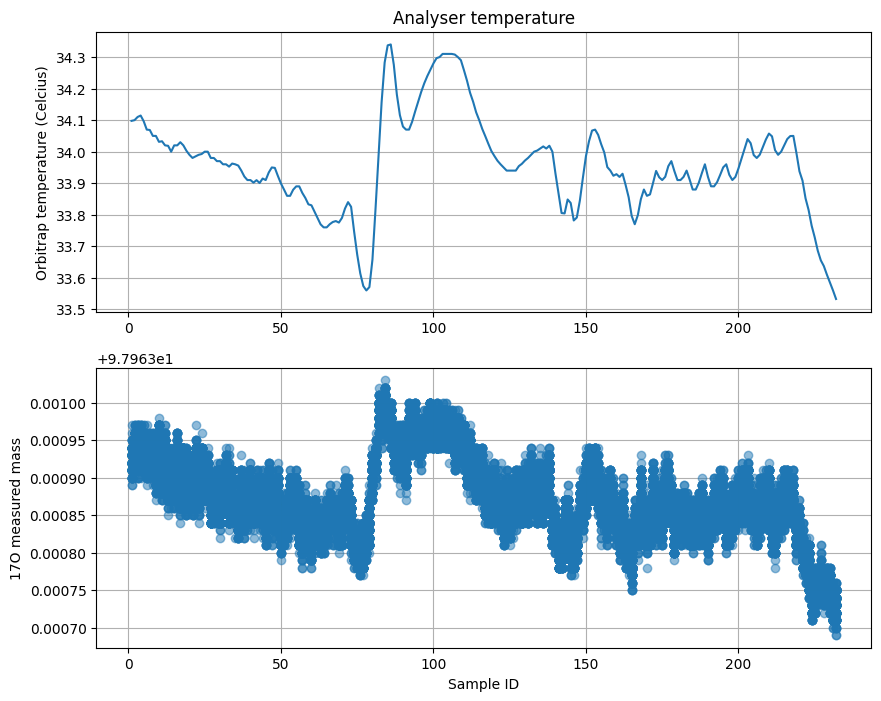

In [5]:
# Check 1:
# plot orbitrap temprature variations during run - variability may affect mass accuracy

fig,ax = plt.subplots(2, figsize=[10,8])
T = data_compiled.groupby('sample_ID')['analyzerTemperature'].mean()
ax[0].plot(T)
ax[0].set_ylabel('Orbitrap temperature (Celcius)')
ax[0].set_title('Analyser temperature')
ax[0].grid()

temp_range = T.max()-T.min()
print(f"Temperature range = {temp_range:.2f} celcius")

iso='17O'
data_i = data_compiled[data_compiled['isotopolog']==iso]
ax[1].plot(data_i['sample_ID'],data_i['mzMeasured'],lw=0,marker='o', alpha=0.5)
ax[1].grid()
ax[1].set_ylabel(iso+' measured mass')
ax[1].set_xlabel('Sample ID')
mz_range = data_i['mzMeasured'].max()-data_i['mzMeasured'].min()
print(f"{iso} peak has m/z range {mz_range*1e3:.2f} mmu")

17O All isotopologue peak resolution ranges are < 3000
17O18O 230 injections with peak resolution range >3000


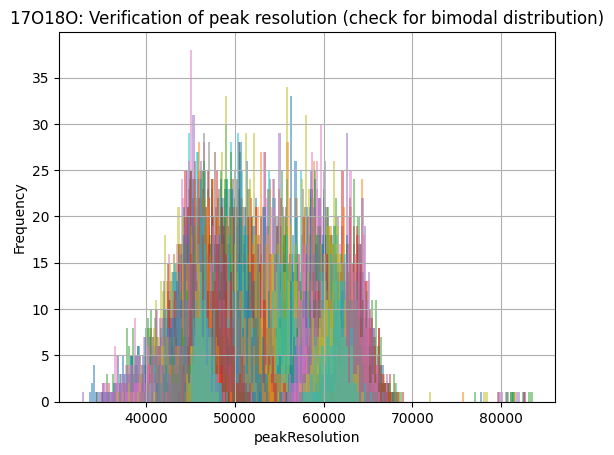

18O All isotopologue peak resolution ranges are < 3000
18O18O 139 injections with peak resolution range >3000


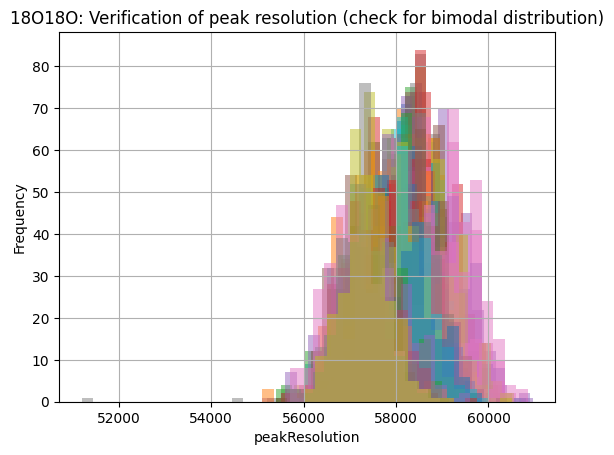

18O34S All isotopologue peak resolution ranges are < 3000
33S All isotopologue peak resolution ranges are < 3000
33S18O All isotopologue peak resolution ranges are < 3000
34S All isotopologue peak resolution ranges are < 3000
34S17O All isotopologue peak resolution ranges are < 3000
36S 1 injections with peak resolution range >3000


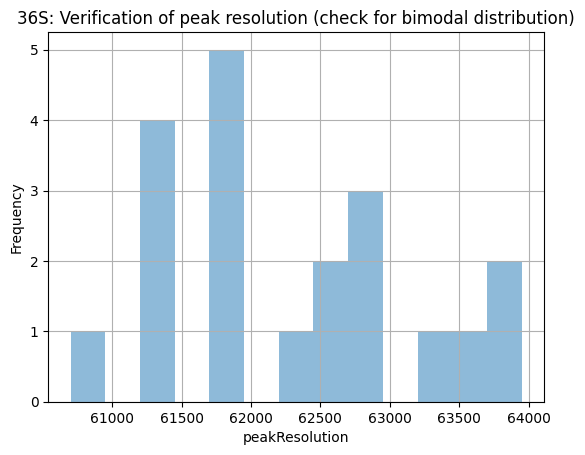

In [6]:
# Check 2:
# verify that the range of peakResolution values < 3000 for all isotopologues

def func(data_single_iso,n,injs):
    # Extract the 'isotopolog' label
    isotopolog_label = iso
    # Plot the histogram
    bin_width=250
    min_val = data_single_iso['peakResolution'].min()
    max_val = data_single_iso['peakResolution'].max()
    if max_val-min_val>3000:
        # print(iso,'Warning: peak resolution range > 3000.','Delta R =',max_val-min_val,'Injection',index)
        n+=1
        injs=[injs]+[index]
        bins = np.arange(min_val, max_val + bin_width, bin_width)
        data_single_iso['peakResolution'].hist(bins=bins,alpha=0.5, label=isotopolog_label)  
    return n
        
    
# Group by 'isotopolog' and apply the function
 # count instances of >3000
for iso in data_compiled['isotopolog'].unique():
    data_compiled_iso=data_compiled[data_compiled['isotopolog']==iso]
    injs=[]
    n=0
    for index, group in data_compiled_iso.groupby([ 'filename']):
        n = func(group, n,injs)
    if n==0:
        print(iso ,'All isotopologue peak resolution ranges are < 3000')
    else:
        print(iso, n,'injections with peak resolution range >3000')
        # Show the plots
        plt.title(iso+': Verification of peak resolution (check for bimodal distribution)')
        plt.xlabel('peakResolution')
        plt.ylabel('Frequency')
        plt.show()


C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\689437683.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(t_list, labels=ID_list, whis=[0,100],vert=False,patch_artist=True)


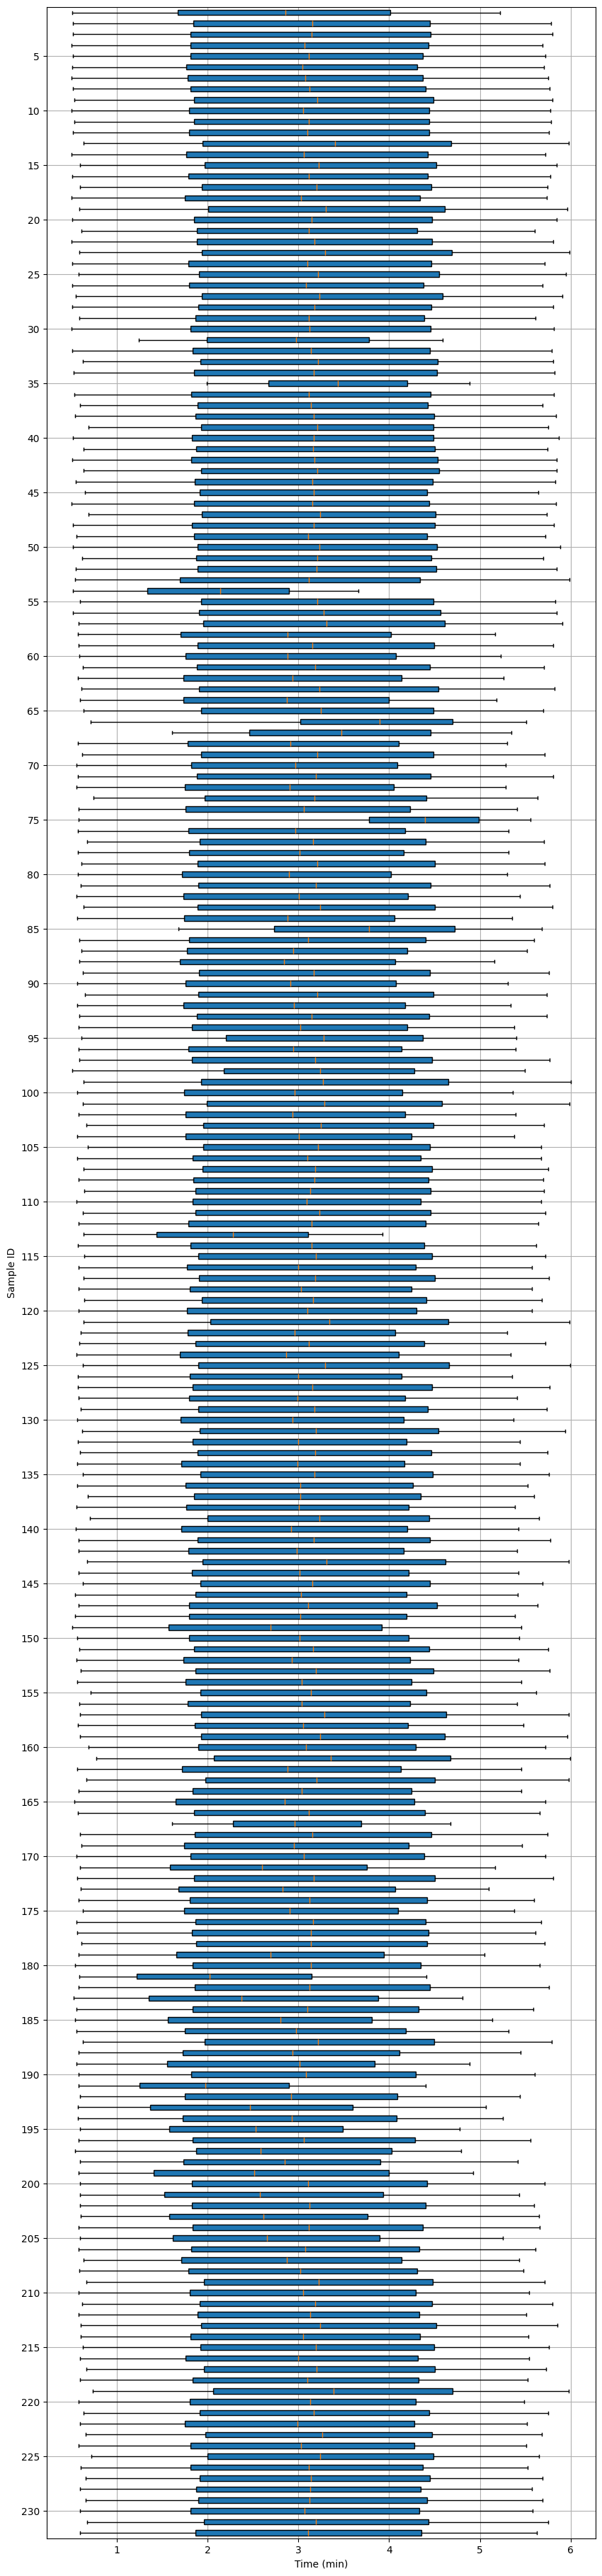

In [7]:
# Check 3:
# plot extracted time periods - check for anomolies

def extract_times(injection_data):
    t = injection_data[['time.min','sample_type']]
    return t

# Group by 'sample_ID' and apply the function
t = data_compiled.groupby('sample_ID').apply(extract_times, include_groups=False)

t_list = [t_group['time.min'].values for name, t_group in t.groupby('sample_ID')]
type_list = [type for type in t.groupby('sample_ID').first()['sample_type']]
ID_list = [int(ID) for ID in t.index.levels[0]]

# colours
colorlist=type_list.copy()
for i,type in enumerate(type_list):
    if type == 'Internal standard':
        colorlist[i]='#1f77b4'
    if type == 'Standard':
        colorlist[i]='#ff7f0e'
    if type == 'Sample':
        colorlist[i]='#2ca02c'
    if type == 'Unknown':
        colorlist[i]='#1f77b4'

fig,ax = plt.subplots(figsize=(10, 0.2*len(ID_list)))
boxplot = ax.boxplot(t_list, labels=ID_list, whis=[0,100],vert=False,patch_artist=True)

# Customizing each box with different colors
for patch, color in zip(boxplot['boxes'], colorlist):
    patch.set_facecolor(color)


ax.set_ylabel('Sample ID')
ax.set_xlabel('Time (min)')
ax.grid()
ax.invert_yaxis()
ax.set_yticks([val for val in ax.get_yticks() if val%5==0])
ax.set_yticklabels([val for val in ax.get_yticks() if val%5==0]);

## 2. Data verification and filtering
#### a. Extract block averages from scan data

In [8]:
# uses groupby() to calculate averages, copies all other data to a summary dataframe 'summ'

data = data_compiled.copy()
data['blockname']=data['filename'].copy()

# Extract blocknames
blocknames = data.groupby('sample_ID').first()['blockname']
isotopologues = [iso for iso in data[data['isotopolog']!=data['basepeak']]['isotopolog'].unique()]
# DataFrame for metadata
summ = pd.DataFrame(columns=['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak']+['ratio_'+iso for iso in isotopologues]+['sem_'+iso for iso in isotopologues]+['start_t_min','stop_t_min','scans','TIC_av','TIC_rse','TICxIT_av','TICxIT_std','integration_t_ms','scan_dur_ms','analyser_temp','notes'],index=blocknames)

for block,data_b in data.groupby('blockname'):
    summ.loc[block,['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak','notes']] = data_b[['sample_ID','filename','sample_type','sample_name','position','blockname','compound','basepeak','notes']].iloc[0]
    bp = data_b.loc[:,'basepeak'].iloc[0]
    
    for iso,data_bi in data_b.groupby('isotopolog'):
        if iso == bp:
            summ.loc[block,'start_t_min'] = data_bi['time.min'].min()
            summ.loc[block,'stop_t_min'] = data_bi['time.min'].max()
            summ.loc[block,'scans'] = len(data_bi)
            summ.loc[block,'TIC_av']= data_bi['tic'].mean()
            TIC_RSE_10scan_rolling = data_bi['tic'].rolling(window=10).std()/data_bi['tic'].rolling(window=10).mean()
            summ.loc[block,'TIC_rse']=  TIC_RSE_10scan_rolling.mean()*np.sqrt(10)
            summ.loc[block,'TICxIT_av']=np.mean(data_bi['tic']*data_bi['it.ms'])
            summ.loc[block,'TICxIT_std']=np.std(data_bi['tic']*data_bi['it.ms'])
            summ.loc[block,'integration_t_ms']= data_bi['it.ms'].mean()
            summ.loc[block,'scan_dur_ms'] = data_bi['time.min'].diff().median()*60*1000
            summ.loc[block,'analyser_temp'] = data_bi['analyzerTemperature'].mean()
        if iso!=bp:
            summ.loc[block,'ratio_'+iso] = data_bi['ratio_to_basepeak'].mean()
            summ.loc[block,'sem_'+iso] = data_bi['ratio_to_basepeak'].sem()
            
print('Loaded '+ str(len(blocknames)) + ' sorted data blocks for samples:\n',summ[summ['sample_type']!='Internal standard']['sample_name'].unique())

summ.groupby('sample_name').first()

Loaded 232 sorted data blocks for samples:
 ['VS-IS' 'DC-1' 'DC-27-28' 'DC-12' 'S1-1' 'DC-34' 'DC-30' 'DC-9' 'DC-16'
 'DC-3' 'MQ-2' 'MeOH' 'VS-1' 'DC-6' 'S2-1' 'VS-2' 'S1-2' 'MQ-1' 'DC-38'
 'S2-2' 'DC-18-20' 'DC-21-24' 'MQ-0']


sample_ID    filename sample_type position   blockname compound  \
sample_name                                                                   
DC-1                9  250203_009     Unknown     B:D7  250203_009      SO4   
DC-12              15  250203_015     Unknown     B:E2  250203_015      SO4   
DC-16              27  250203_027     Unknown     B:E3  250203_027      SO4   
DC-18-20           99  250203_099     Unknown     B:E4  250203_099      SO4   
DC-21-24          109  250203_109     Unknown     B:E5  250203_109      SO4   
DC-27-28           13  250203_013     Unknown     B:E6  250203_013      SO4   
DC-3               29  250203_029     Unknown     B:D8  250203_029      SO4   
DC-30              21  250203_021     Unknown     B:E7  250203_021      SO4   
DC-34              19  250203_019     Unknown     B:E8  250203_019      SO4   
DC-38              73  250203_073     Unknown     B:E9  250203_073      SO4   
DC-6               41  250203_041     Unknown     B:D9  250203_041      SO4   
DC-9               23  250203_023     Unknown     B:E1  250203_023      SO4   
MQ-0              167  250203_167     Unknown     B:C2  250203_167      SO4   
MQ-1               67  250203_067     Unknown     B:C3  250203_067      SO4   
MQ-2               31  250203_031     Unknown     B:C4  250203_031      SO4   
MeOH               35  250203_035     Unknown     B:C1  250203_035      SO4   
S1-1               17  250203_017     Unknown     B:D1  250203_017      SO4   
S1-2               53  250203_053     Unknown     B:D4  250203_053      SO4   
S2-1               45  250203_045     Unknown     B:D2  250203_045      SO4   
S2-2               81  250203_081     Unknown     B:D5  250203_081      SO4   
VS-1               37  250203_037     Unknown     B:D3  250203_037      SO4   
VS-2               49  250203_049     Unknown     B:D6  250203_049      SO4   
VS-IS               1  250203_001     Unknown     B:F9  250203_001      SO4   

            basepeak ratio_17O ratio_17O18O ratio_18O  ... stop_t_min scans  \
sample_name                                            ...                    
DC-1             34S  0.027367     0.000182  0.106986  ...      5.802   297   
DC-12            34S  0.027633     0.000181  0.108005  ...      5.849   299   
DC-16            34S  0.027941     0.000183  0.108266  ...      5.905   302   
DC-18-20         34S  0.028378     0.000182  0.108947  ...      5.999   304   
DC-21-24         34S  0.028237     0.000184  0.107572  ...      5.705   287   
DC-27-28         34S   0.02808     0.000178  0.109847  ...      5.983   305   
DC-3             34S  0.027643     0.000182   0.10649  ...      5.615   282   
DC-30            34S  0.027968      0.00018  0.108161  ...      5.606   285   
DC-34            34S  0.027806      0.00018  0.108026  ...      5.963   305   
DC-38            34S   0.02813     0.000188  0.106557  ...      5.636   279   
DC-6             34S  0.027734     0.000181  0.105863  ...      5.748   290   
DC-9             34S  0.027614     0.000179  0.106979  ...      5.989   307   
MQ-0             34S  0.029885     0.000189   0.12775  ...      4.679    37   
MQ-1             34S  0.030352     0.000186  0.137445  ...      5.349    23   
MQ-2             34S   0.03116         None  0.153695  ...      4.588    20   
MeOH             34S  0.030832         None  0.167989  ...      4.883    18   
S1-1             34S  0.027986     0.000187  0.109321  ...      5.743   293   
S1-2             34S  0.028244     0.000186  0.108281  ...      5.986   268   
S2-1             34S     0.028     0.000186  0.108123  ...      5.647   283   
S2-2             34S  0.027896     0.000183   0.10752  ...       5.77   293   
VS-1             34S  0.028419     0.000189  0.110407  ...      5.691   288   
VS-2             34S  0.028437      0.00019  0.110304  ...      5.723   292   
VS-IS            34S  0.027958     0.000192  0.111612  ...      5.224   266   

                      TIC_av   TIC_rse          TICxIT_av   

#### b. Plot TIC and time between scans
- If time between scans varies, less scans than the maximum are being made
- If time between scans varies but no longer 

Text(0.5, 1.0, 'TIC (L), Scan Interval (R)')

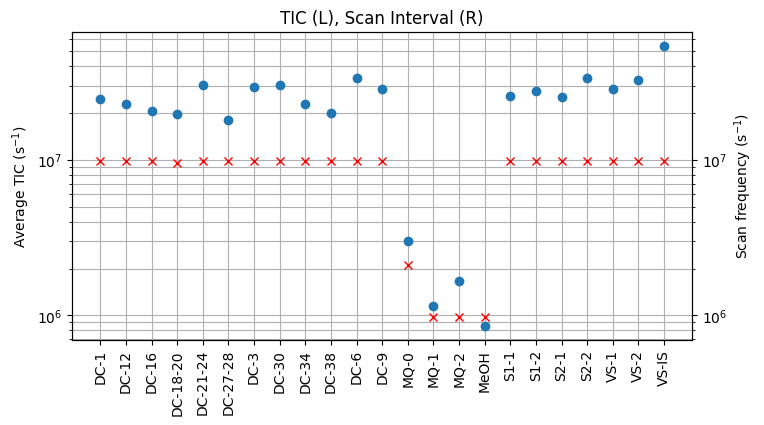

In [9]:
pd.set_option('display.float_format', '{:.2g}'.format)
TICs = summ[['sample_name','TIC_av']].groupby('sample_name').mean()
scandurs = summ[['sample_name','scan_dur_ms']].groupby('sample_name').mean()/1000

fig,ax=plt.subplots(figsize=[8,4])
ax.plot(TICs, lw=0, marker = 'o')
ax.set_yscale('log')
ax.set_ylabel('Average TIC (s$^{-1}$)')
plt.xticks(rotation=90);

ax2=ax.twinx()
ax2.plot(1e7/scandurs, lw=0, marker = 'x',c='r',ms=6)
ax2.set_ylabel('Scan frequency (s$^{-1}$)')
plt.xticks(rotation=90)
ax2.set_yscale('log')
ax2.set_ylim([ax.get_ylim()[0],ax.get_ylim()[1]])

ax.grid(axis='both',which='both')
ax.set_title('TIC (L), Scan Interval (R)')

### c. Check for outlying blocks

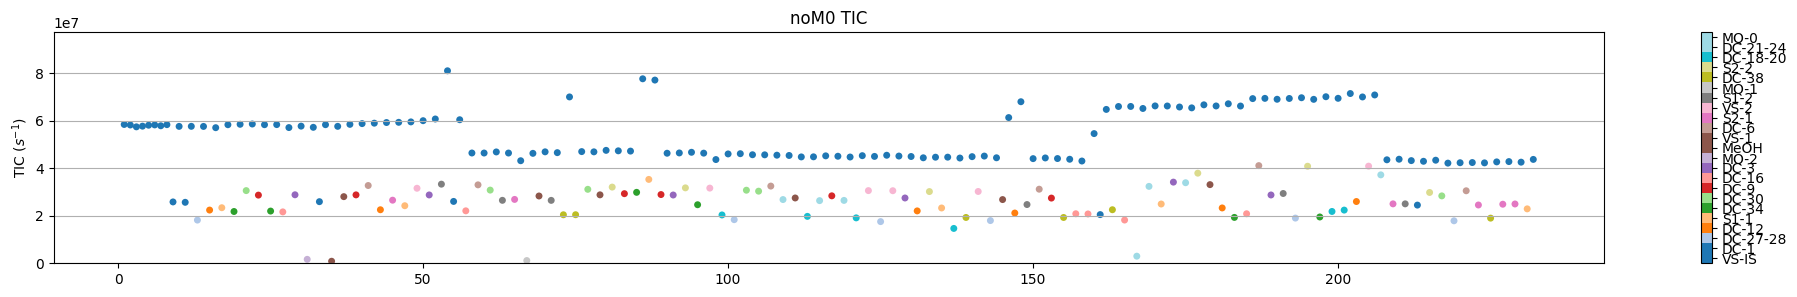

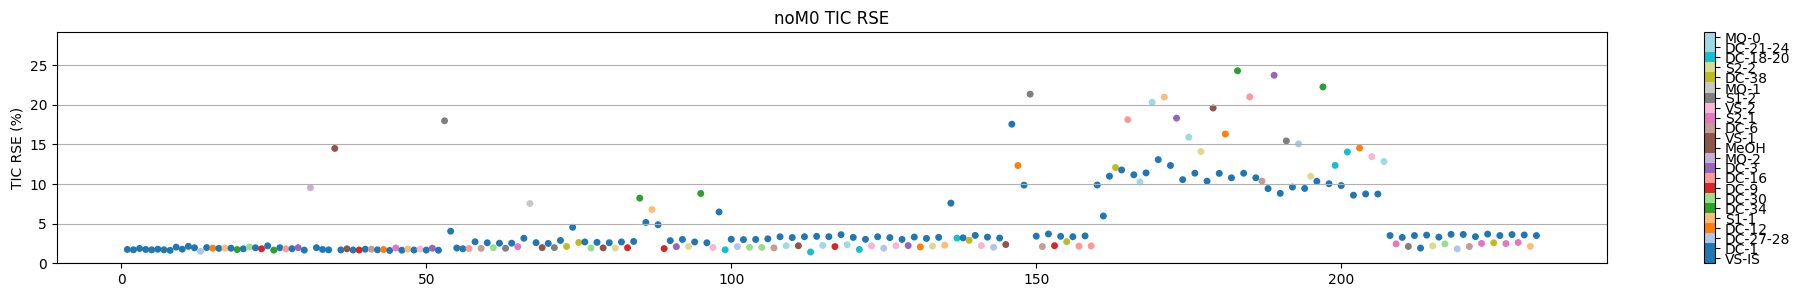

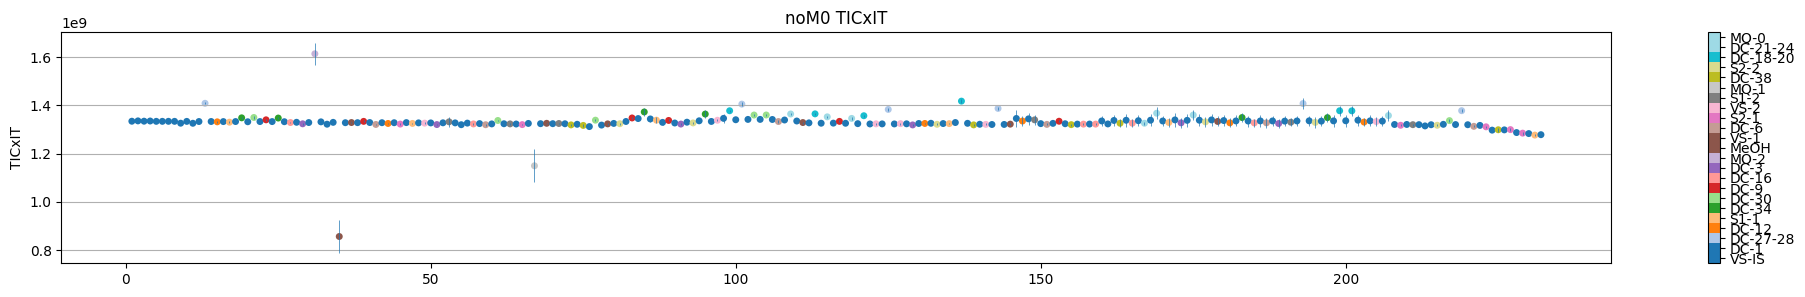

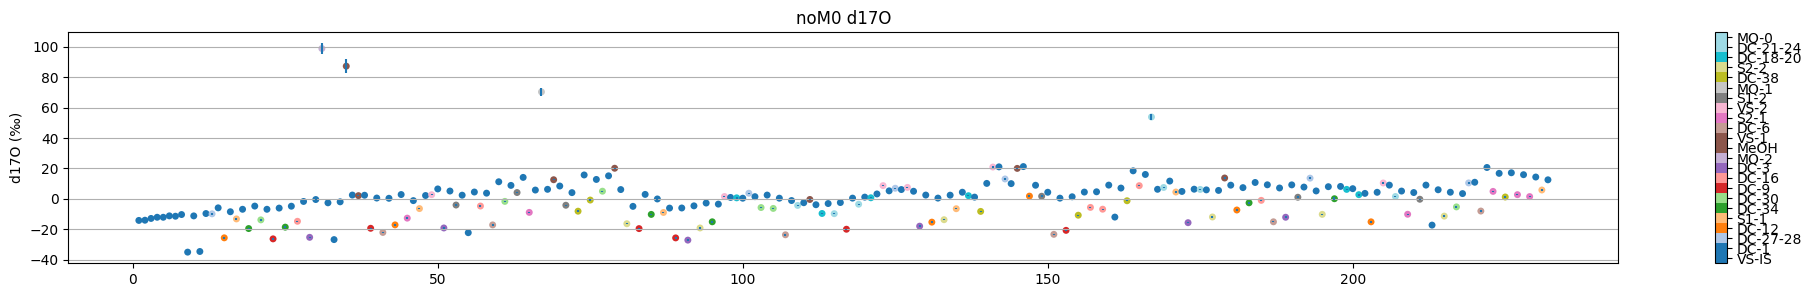

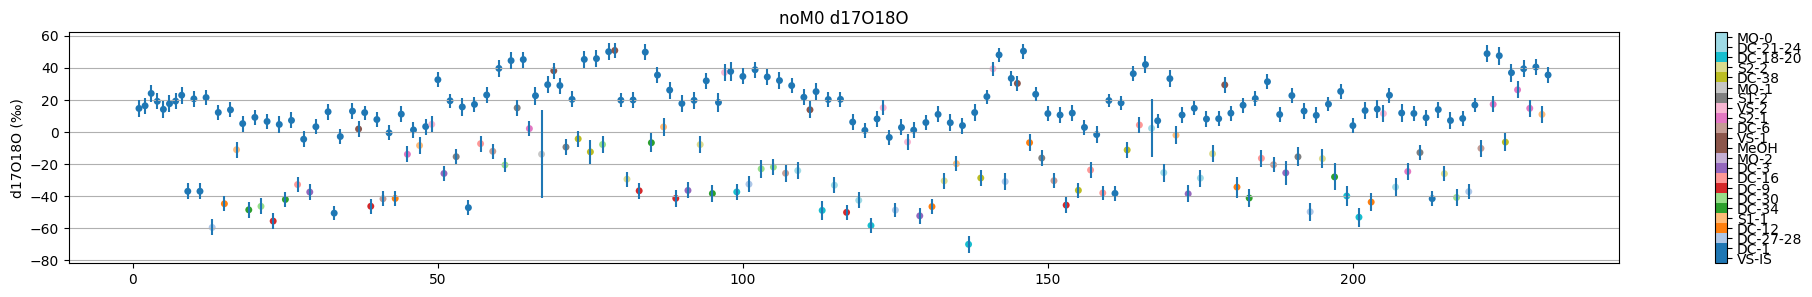

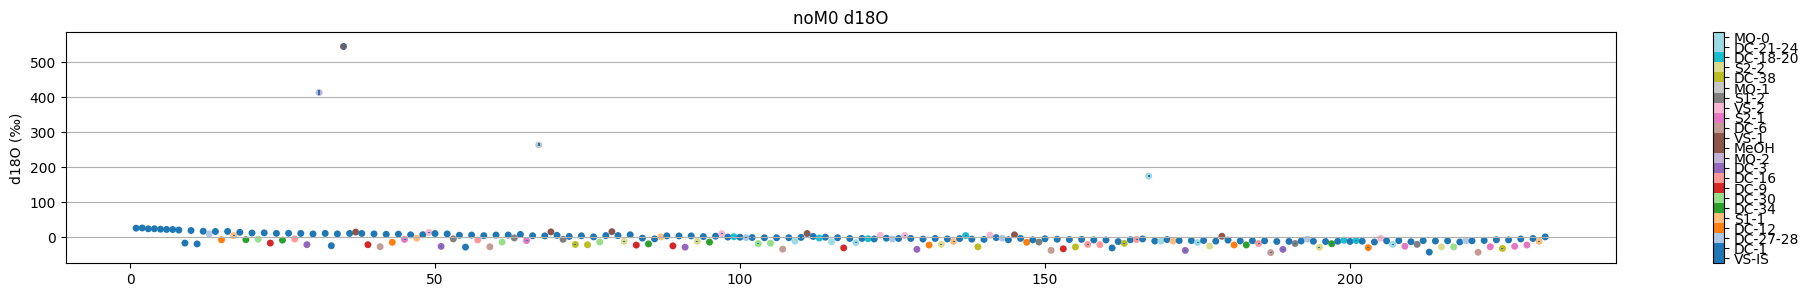

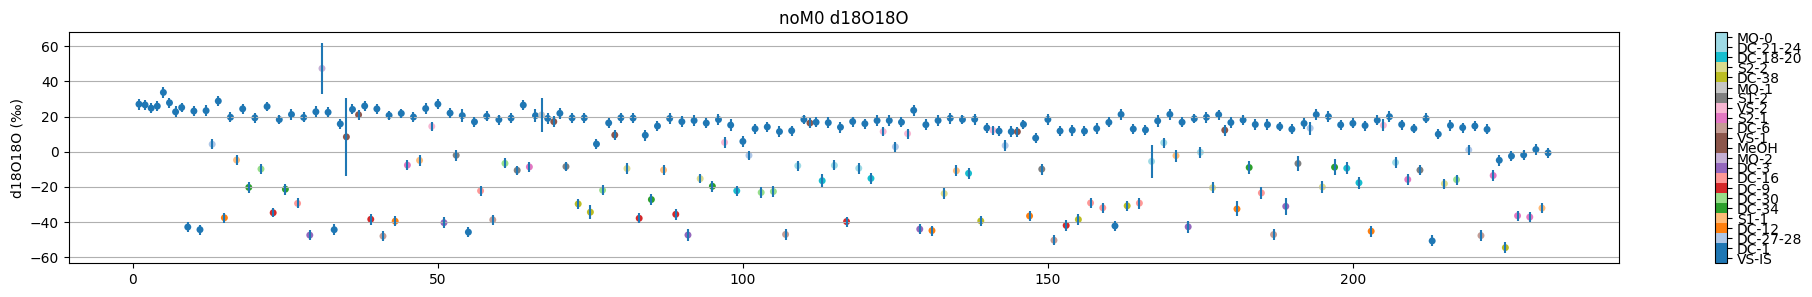

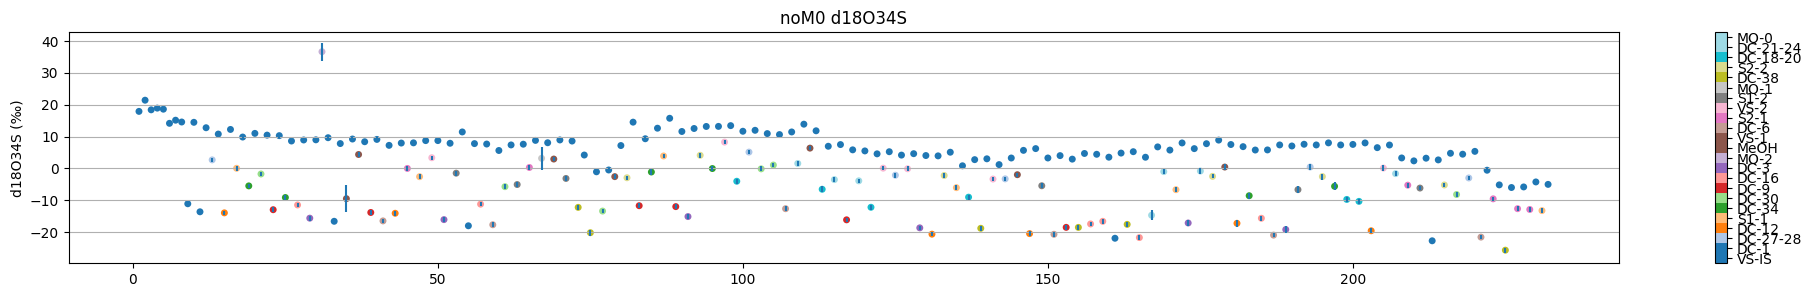

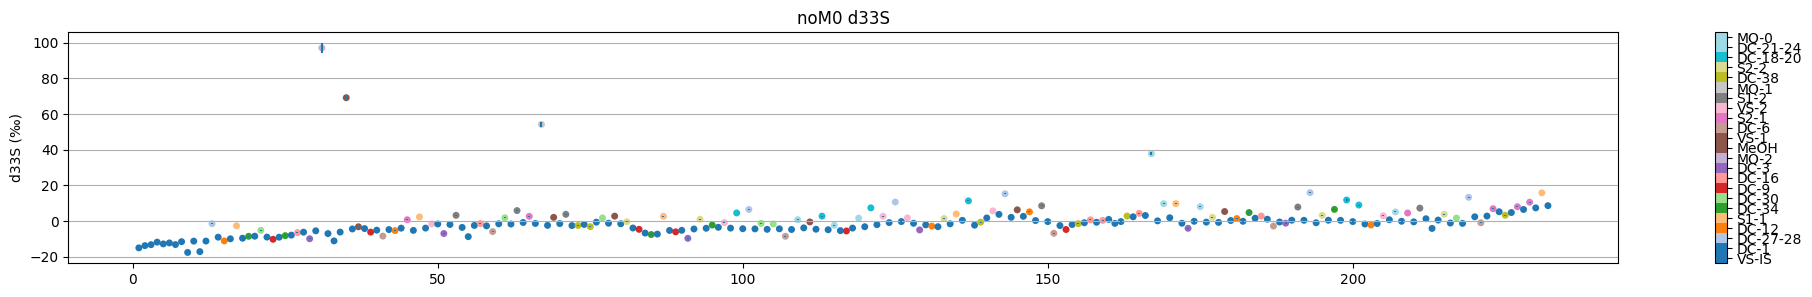

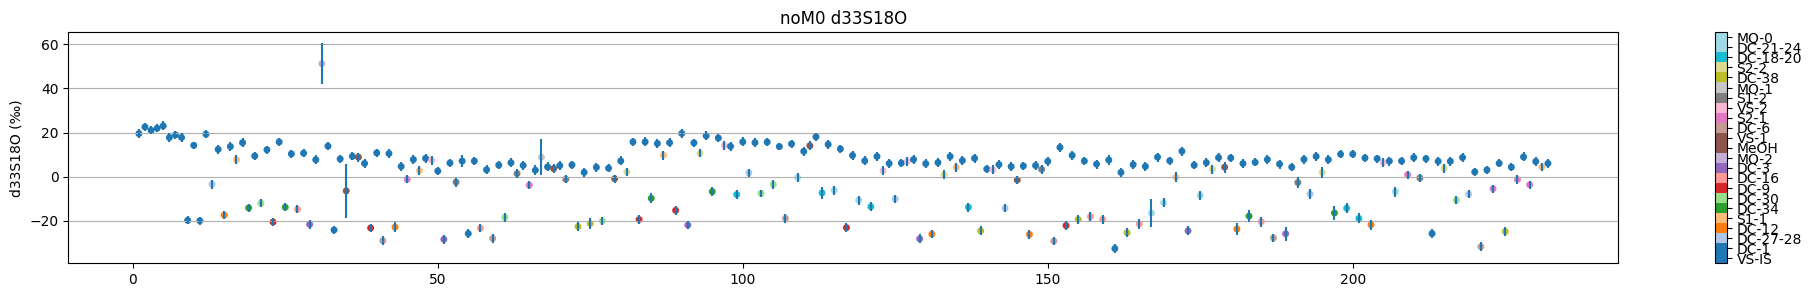

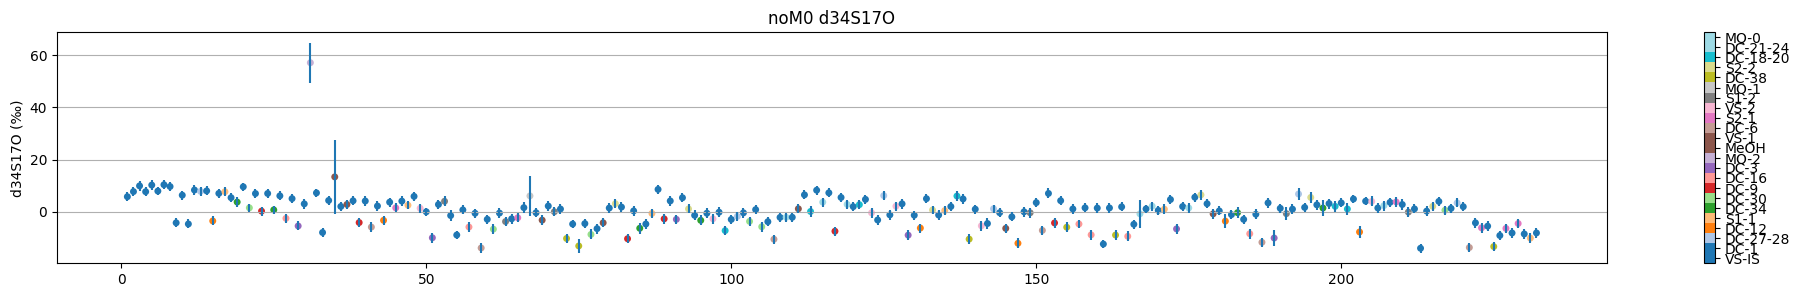

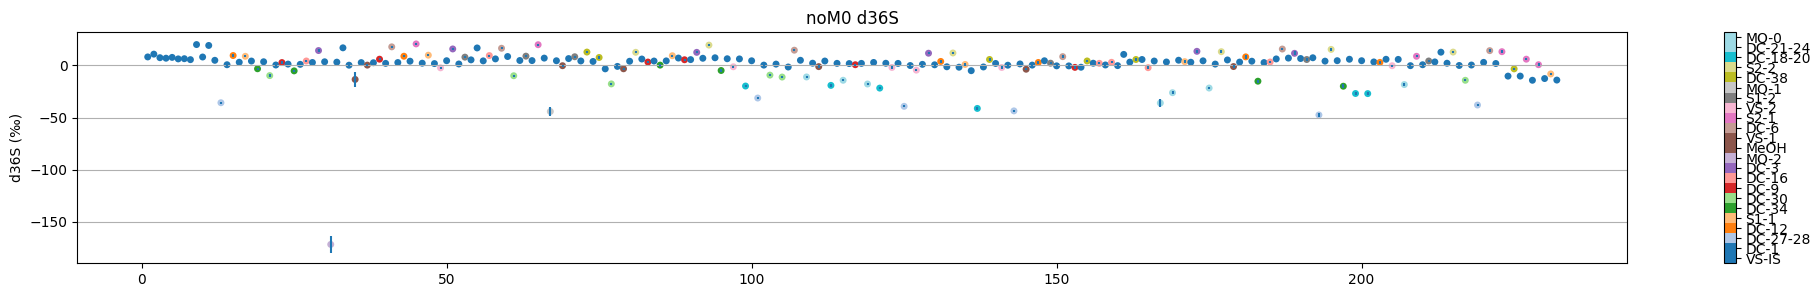

In [10]:
blocknames = summ.index
rcols = summ.columns[[col.startswith('ratio') for col in summ.columns]]

# identify M0 and/or noM0 experiments
exp_list = summ['basepeak'].unique()
for i,bp in enumerate(exp_list):
    if bp!='M0':
        exp_list[i]='noM0'

# separate M0 and noM0 data
for k,bp in enumerate(summ['basepeak'].unique()):
    summ1 = summ[summ['basepeak']==bp]
    if bp!='M0':
        exp='noM0'
    else:
        exp='M0'
    
    # colour mapping
    categories = summ1['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])
    discrete_cmap = plt.colormaps.get_cmap('tab20')

    # TIC plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(summ1['sample_ID'], summ1['TIC_av'], c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TIC ($s^{-1}$)')
    ax.set_title(exp+' TIC')
    ax.set_ylim([0,1.2*max(summ1['TIC_av'])])
    
    # TIC RSE plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(summ1['sample_ID'], summ1['TIC_rse']*100, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TIC RSE (%)')
    ax.set_title(exp+' TIC RSE')
    ax.set_ylim([0,120*max(summ1['TIC_rse'])])
    
    # TICxIT plot
    fig,ax=plt.subplots(figsize=[25,3])
    scatter = ax.scatter(x=summ1['sample_ID'],  # x-values
                      y=summ1['TICxIT_av'],  # y-values
                      c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
    ax.errorbar(x=summ1['sample_ID'], y=summ1['TICxIT_av'], yerr=summ1['TICxIT_std'], lw=0.5,ls='none',fmt='none')
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax.grid(True, axis='y')
    ax.set_ylabel('TICxIT')
    ax.set_title(exp+' TICxIT')

    # isotopologue ratio plots
    for i,col in enumerate(rcols):
        # check for empty column
        if len(summ1[col].dropna())>1:
            fig,ax=plt.subplots(figsize=[25,3])
            scatter = ax.scatter(summ1['sample_ID'], (summ1[col]/summ1[col].mean()-1)*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.', s=100)
            ax.errorbar(summ1['sample_ID'], (summ1[col]/summ1[col].mean()-1)*1000, yerr=(summ1['sem_'+col[6:]]/summ1[col])*1000, fmt='none')
            cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
            cbar.set_ticklabels(categories.unique())
            ax.grid(True, axis='y')
            ax.set_ylabel('d' + col.split('_')[-1] + ' (‰)')
            ax.set_title(exp+' d' + col.split('_')[-1])



### d. Plot TIC and rolling $\delta^{18}O$ for each block, check for outliers
Input: meandur (rolling mean duration in minutes)

<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_28324\3901015417.py:32: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_ylabel('$\delta^{18}O$ (‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_28324\3901015417.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(3, figsize = [10,5])


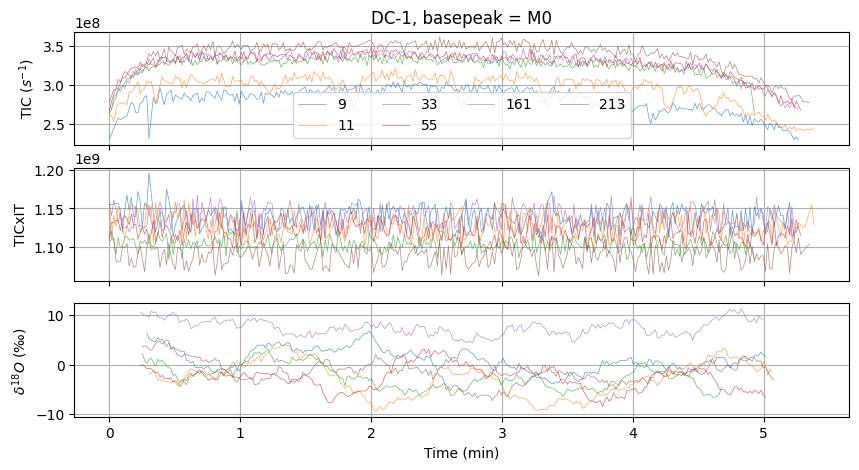

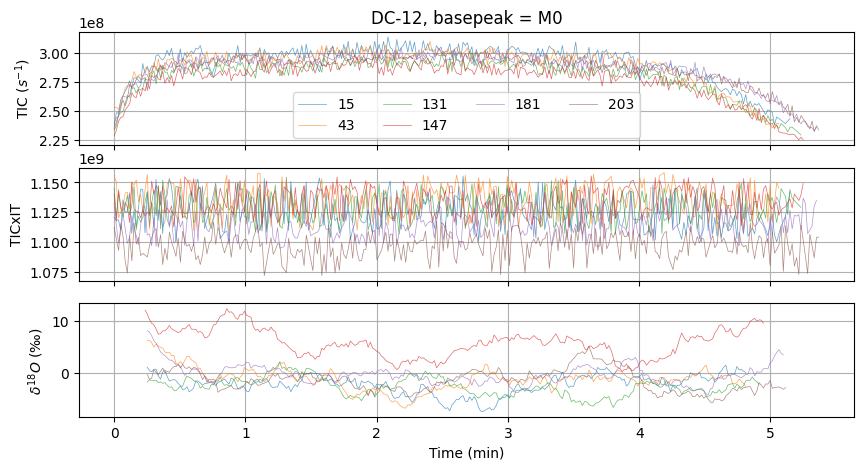

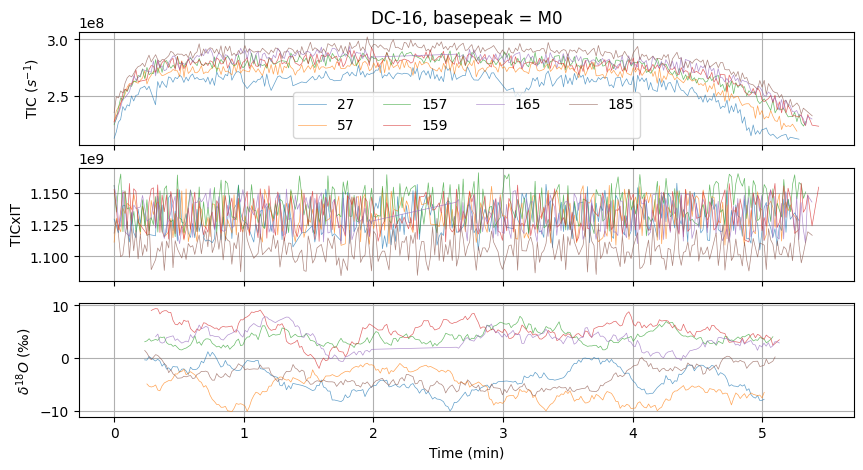

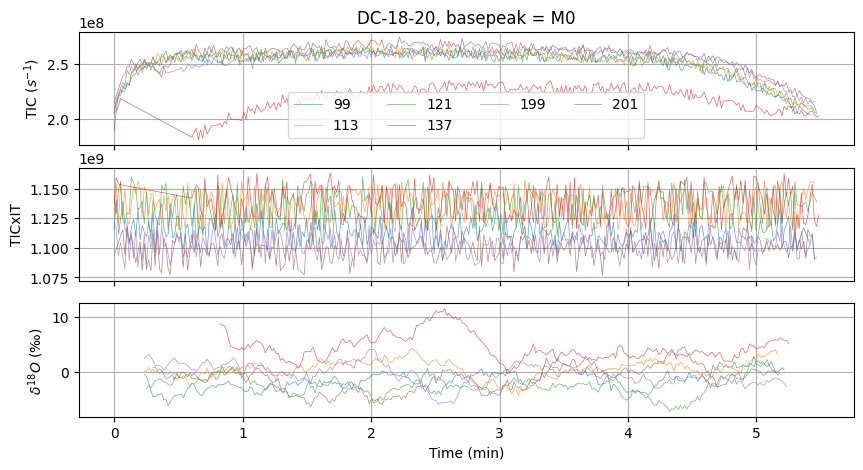

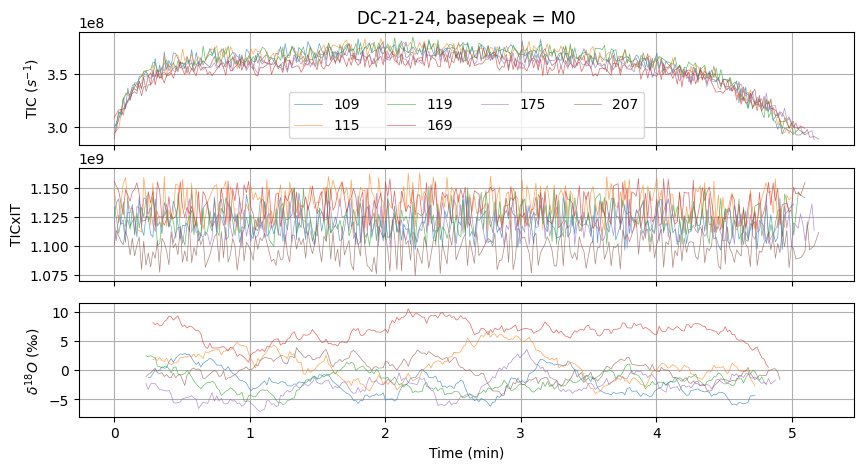

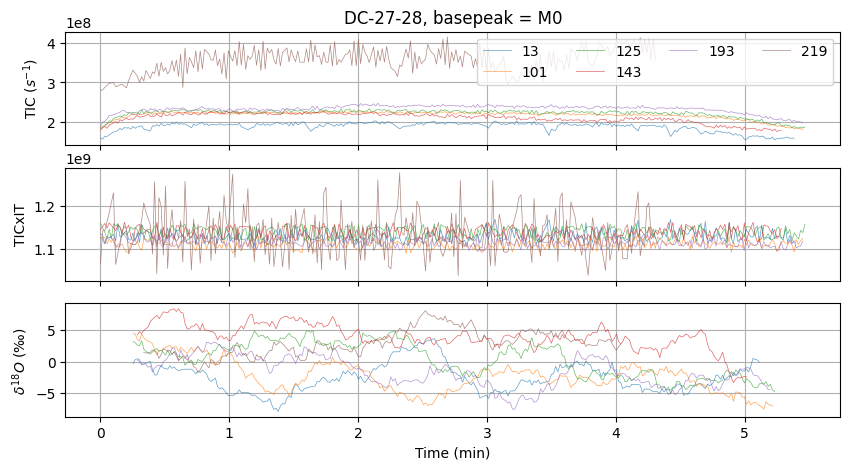

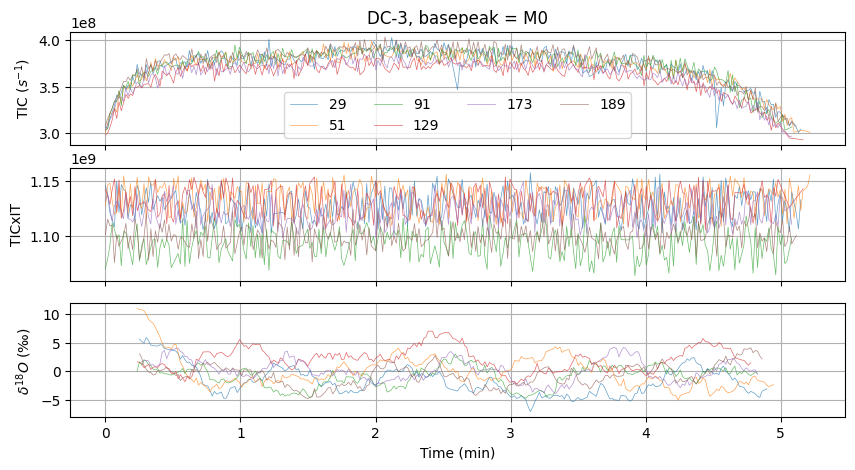

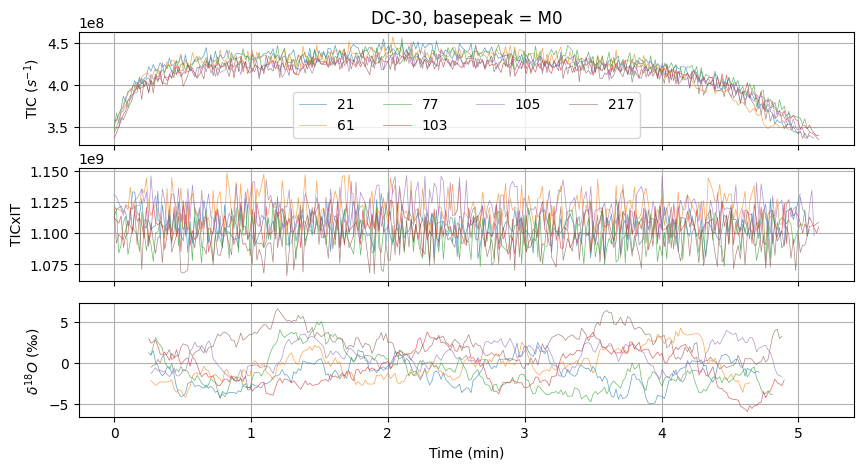

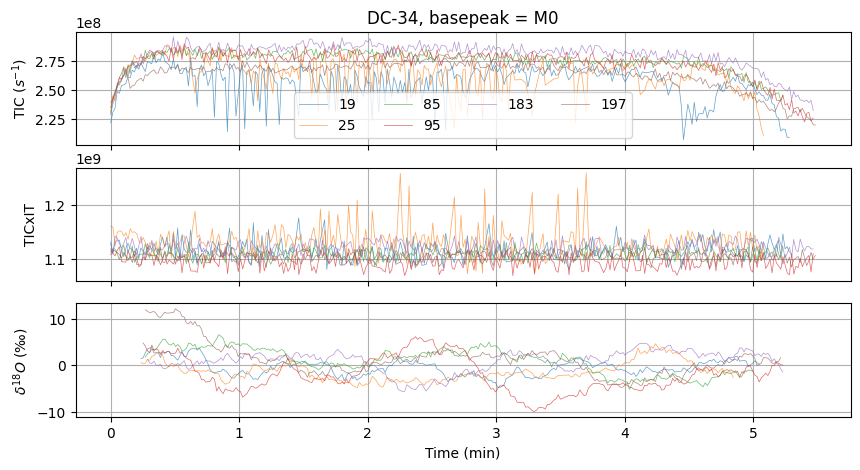

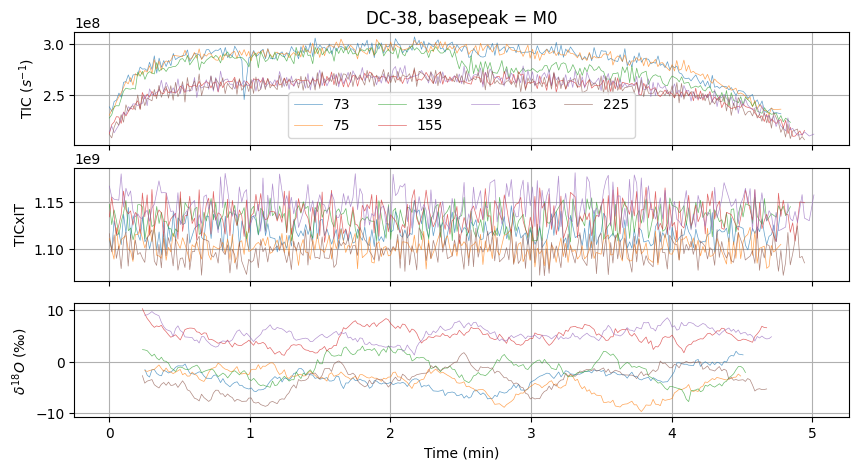

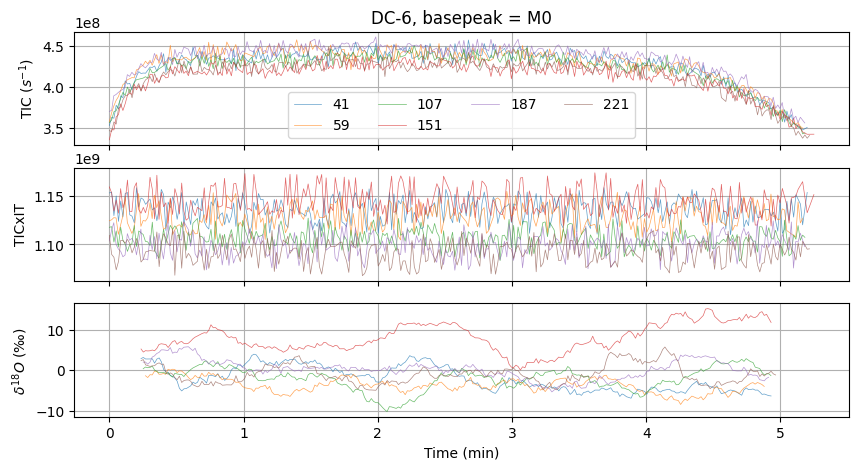

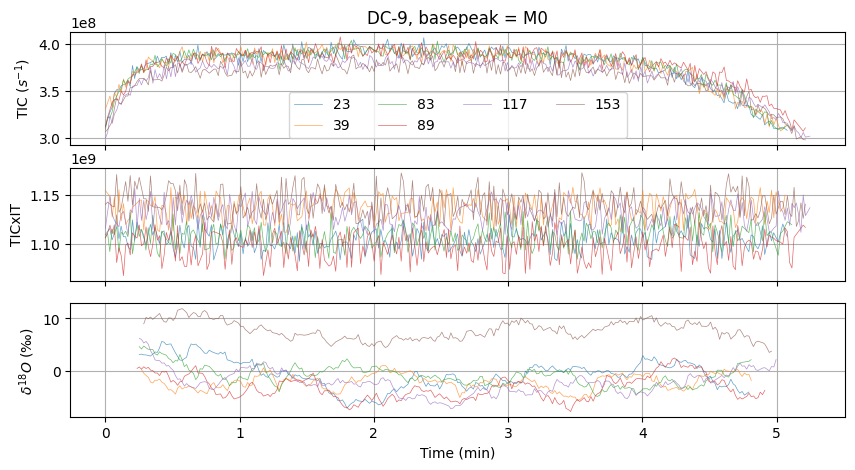

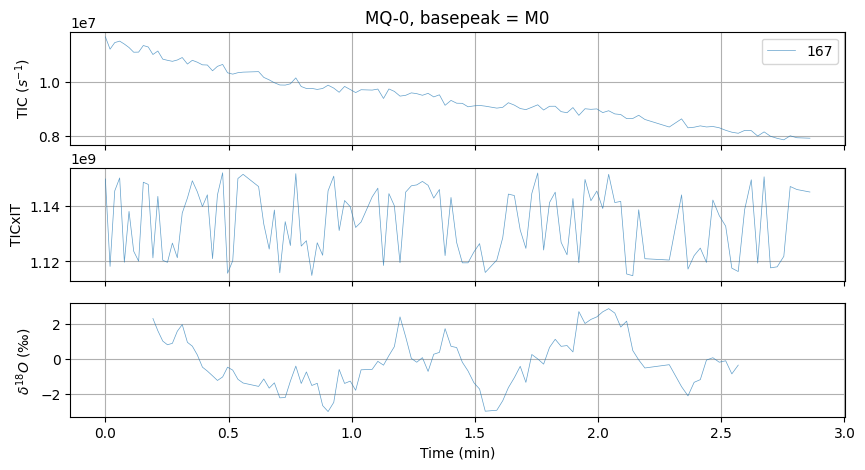

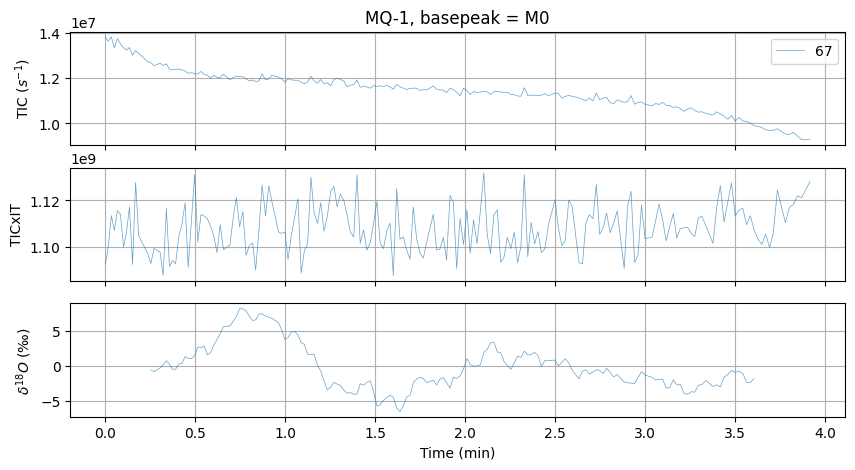

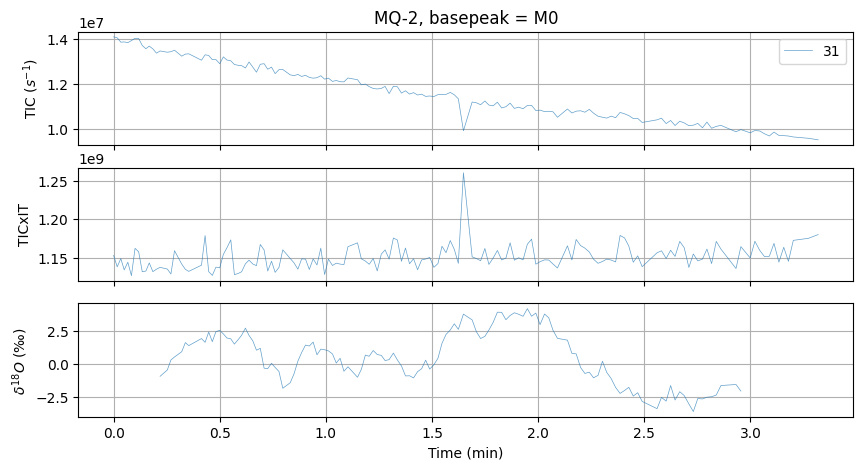

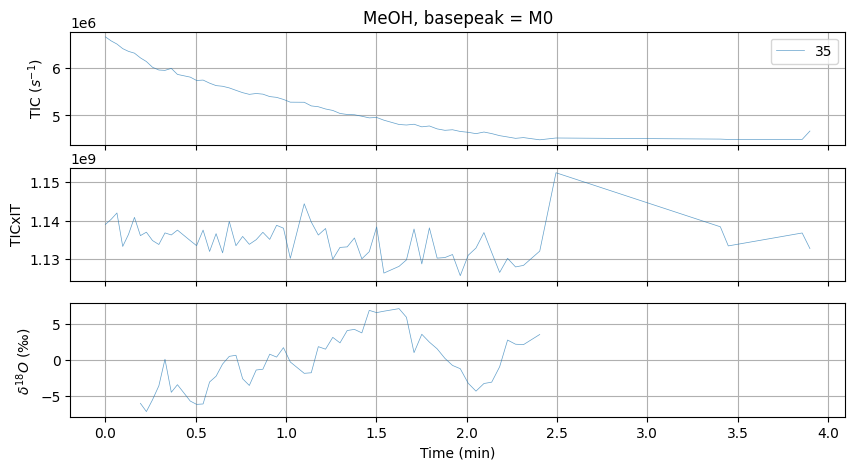

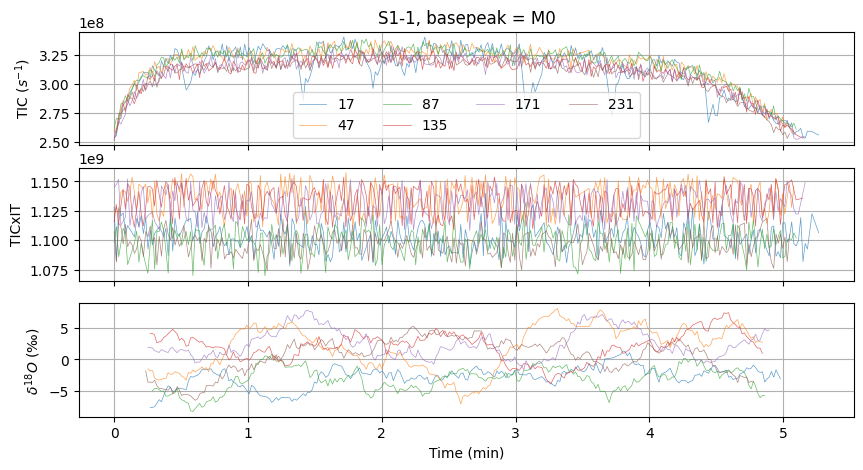

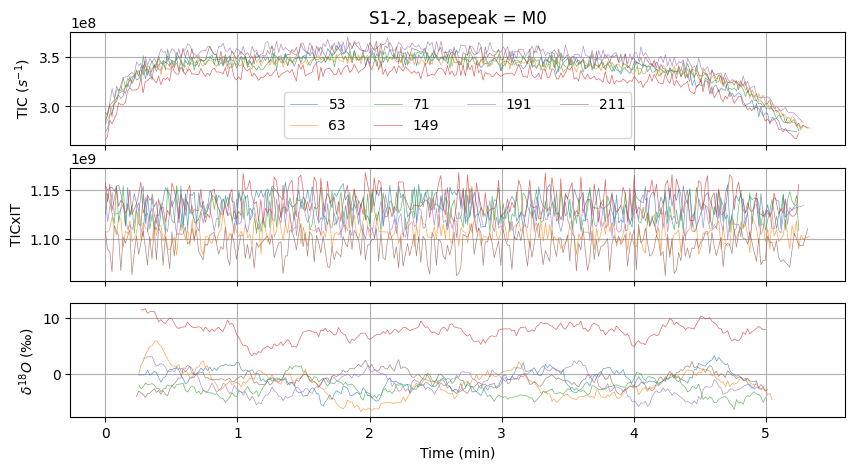

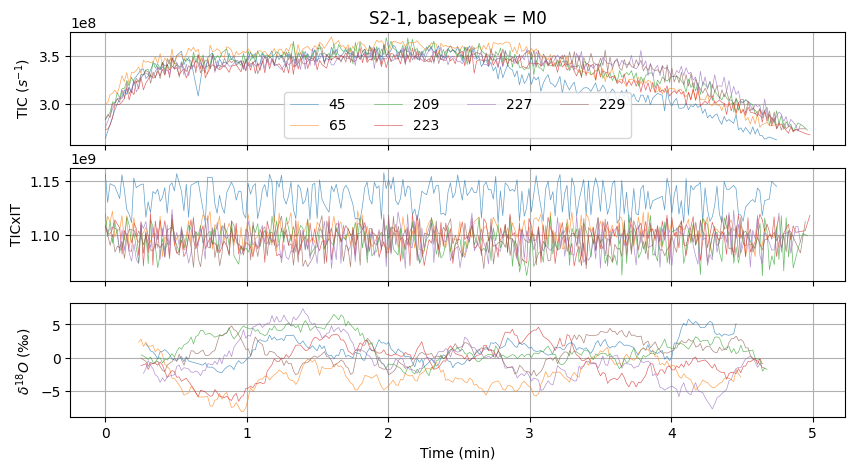

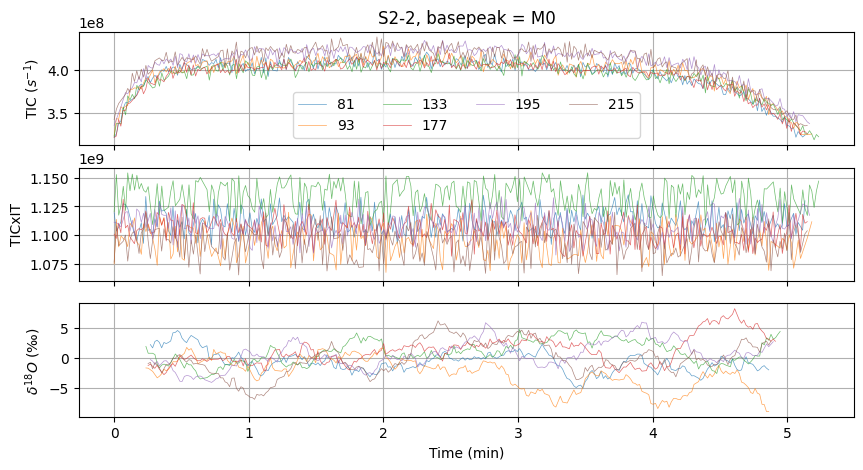

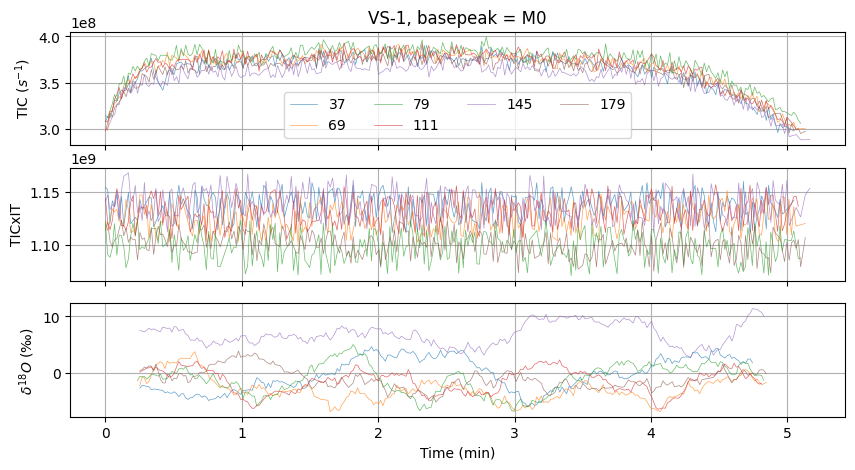

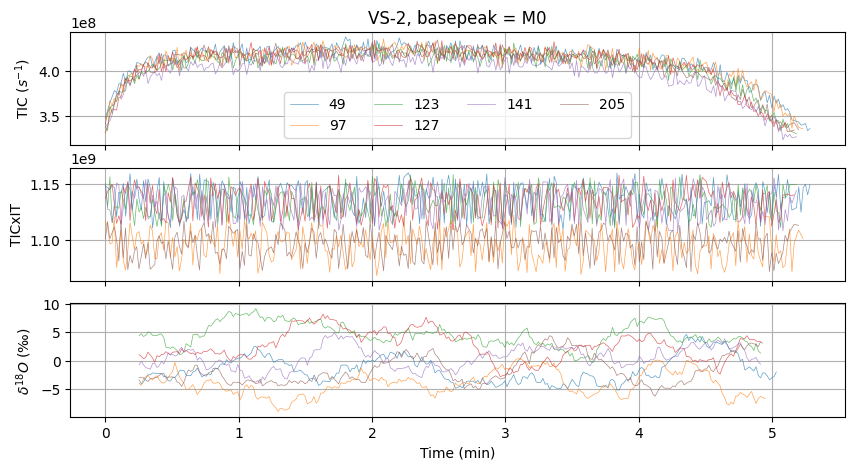

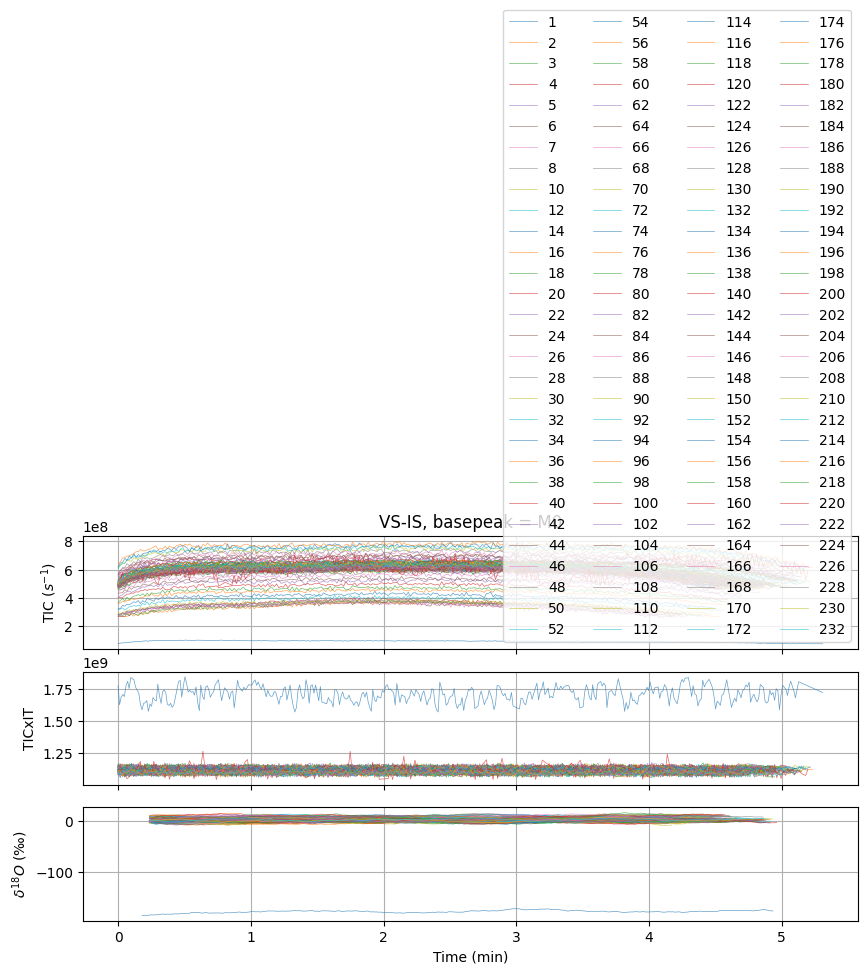

In [40]:
for (sample,basepeak), data_sb in data_compiled[data_compiled['isotopolog']=='18O'].groupby(['sample_name','basepeak']):
    
    fig,ax = plt.subplots(3, figsize = [10,5])
    ax[0].set_title(sample +', basepeak = '+basepeak)
    
    ref_18O = data_sb['ratio_to_basepeak'].mean()
                
    for sample_ID, data_sbi in data_sb.groupby('sample_ID'):
        
        scandur = data_sb['time.min'].diff().median()
        meandur = 0.5  # minutes for rolling mean calculation
        window_size = int(meandur / scandur)
        if basepeak=='M0':
            data_sbi['Rolling_18O'] = data_sbi['ratio_to_basepeak'].rolling(window=window_size, center=True).mean()
        else:
            data_sbi['Rolling_18O'] = data_sbi['ratio_to_basepeak'].rolling(window=int(window_size/2), center=True).mean()
                
        ax[0].plot(data_sbi['time.min']-data_sbi['time.min'].min(),data_sbi['tic'], label=sample_ID, lw=0.5,alpha=0.7)
        ax[0].grid(True,axis='both')
        ax[0].set_ylabel('TIC ($s^{-1}$)')
        ax[0].legend(ncols=4)        
        ax[0].set_xticklabels([])

        ax[1].plot(data_sbi['time.min']-data_sbi['time.min'].min(),data_sbi['tic']*data_sbi['it.ms'], label=sample_ID, lw=0.5,alpha=0.7)
        ax[1].grid(True,axis='both')
        ax[1].set_ylabel('TICxIT')   
        ax[1].set_xticklabels([])

        ax[2].plot(data_sbi['time.min']-data_sbi['time.min'].min(),1000*(data_sbi['Rolling_18O']/ref_18O-1), lw=0.5,alpha=0.7)
        ax[2].set_xlim(ax[0].get_xlim())
        ax[2].grid(True,axis='both')
        ax[2].set_ylabel('$\delta^{18}O$ (‰)')


        ax[-1].set_xlabel('Time (min)')

### e. Block filtering
Remove unfaithful injections using filters or by hand   
Saves a filtered summary file '_summary_filtered.csv'

In [11]:
print('List of the first occurence of each sample name')

summ.groupby('sample_name').first().sort_values('sample_ID')
# summ[['sample_name','experiment']]

List of the first occurence of each sample name


sample_ID    filename sample_type position   blockname compound  \
sample_name                                                                   
VS-IS               1  250203_001     Unknown     B:F9  250203_001      SO4   
DC-1                9  250203_009     Unknown     B:D7  250203_009      SO4   
DC-27-28           13  250203_013     Unknown     B:E6  250203_013      SO4   
DC-12              15  250203_015     Unknown     B:E2  250203_015      SO4   
S1-1               17  250203_017     Unknown     B:D1  250203_017      SO4   
DC-34              19  250203_019     Unknown     B:E8  250203_019      SO4   
DC-30              21  250203_021     Unknown     B:E7  250203_021      SO4   
DC-9               23  250203_023     Unknown     B:E1  250203_023      SO4   
DC-16              27  250203_027     Unknown     B:E3  250203_027      SO4   
DC-3               29  250203_029     Unknown     B:D8  250203_029      SO4   
MQ-2               31  250203_031     Unknown     B:C4  250203_031      SO4   
MeOH               35  250203_035     Unknown     B:C1  250203_035      SO4   
VS-1               37  250203_037     Unknown     B:D3  250203_037      SO4   
DC-6               41  250203_041     Unknown     B:D9  250203_041      SO4   
S2-1               45  250203_045     Unknown     B:D2  250203_045      SO4   
VS-2               49  250203_049     Unknown     B:D6  250203_049      SO4   
S1-2               53  250203_053     Unknown     B:D4  250203_053      SO4   
MQ-1               67  250203_067     Unknown     B:C3  250203_067      SO4   
DC-38              73  250203_073     Unknown     B:E9  250203_073      SO4   
S2-2               81  250203_081     Unknown     B:D5  250203_081      SO4   
DC-18-20           99  250203_099     Unknown     B:E4  250203_099      SO4   
DC-21-24          109  250203_109     Unknown     B:E5  250203_109      SO4   
MQ-0              167  250203_167     Unknown     B:C2  250203_167      SO4   

            basepeak ratio_17O ratio_17O18O ratio_18O  ... stop_t_min scans  \
sample_name                                            ...                    
VS-IS            34S     0.028      0.00019      0.11  ...        5.2   266   
DC-1             34S     0.027      0.00018      0.11  ...        5.8   297   
DC-27-28         34S     0.028      0.00018      0.11  ...          6   305   
DC-12            34S     0.028      0.00018      0.11  ...        5.8   299   
S1-1             34S     0.028      0.00019      0.11  ...        5.7   293   
DC-34            34S     0.028      0.00018      0.11  ...          6   305   
DC-30            34S     0.028      0.00018      0.11  ...        5.6   285   
DC-9             34S     0.028      0.00018      0.11  ...          6   307   
DC-16            34S     0.028      0.00018      0.11  ...        5.9   302   
DC-3             34S     0.028      0.00018      0.11  ...        5.6   282   
MQ-2             34S     0.031         None      0.15  ...        4.6    20   
MeOH             34S     0.031         None      0.17  ...        4.9    18   
VS-1             34S     0.028      0.00019      0.11  ...        5.7   288   
DC-6             34S     0.028      0.00018      0.11  ...        5.7   290   
S2-1             34S     0.028      0.00019      0.11  ...        5.6   283   
VS-2             34S     0.028      0.00019      0.11  ...        5.7   292   
S1-2             34S     0.028      0.00019      0.11  ...          6   268   
MQ-1             34S      0.03      0.00019      0.14  ...        5.3    23   
DC-38            34S     0.028      0.00019      0.11  ...        5.6   279   
S2-2             34S     0.028      0.00018      0.11  ...        5.8   293   
DC-18-20         34S     0.028      0.00018      0.11  ...          6   304   
DC-21-24         34S     0.028      0.00018      0.11  ...        5.7   287   
MQ-0             34S      0.03      0.00019      0.13  ...        4.7    37   

             TIC_av TIC_rse TICxIT_av TICxIT_std integration

In [21]:
# filter blocks using to_remove.csv
to_remove_filtering=False
# filter blocks manually using code below
manual_filtering=True

summ['to_remove'] = False

# load samples to remove from file
if os.path.exists(os.path.join(pathresults,'to_remove.csv'))&to_remove_filtering==True:
    to_remove = pd.read_csv(os.path.join(pathresults,'to_remove.csv'),index_col='blockname')

    for i,block in enumerate(summ['blockname']):
        if block not in to_remove.index:
            print(block, 'not found in to_remove')
        elif to_remove.loc[block,'to_remove']==True:
            summ['to_remove'] = summ['to_remove']|(summ['blockname']==block)
            print(block, 'removed using to_remove')
    
# specify files to remove manually
if manual_filtering==True:

    # remove first row
    firstrow=summ[summ['sample_ID']==1]
    firstrow['to_remove']=True
    summ[summ['sample_ID']==1]=firstrow
    print('Removed first block: \n'+ str(list(summ[summ['to_remove']][['sample_name','blockname']])))

    # blank filter
    if True:
        summ['to_remove'] = summ['sample_name'].str.startswith(('MeOH','MQ'))
        print('Removed '+str(len(summ[summ['to_remove']])) + ' blank blocks: \n'+ str(list(summ[summ['to_remove']][['sample_name','blockname']])))

    # minimum TIC filter
    if True:
        minTIC=1e6
        summ['to_remove'] = summ['to_remove']|(summ['TIC_av']<minTIC)
        print('\nRemoved '+str(len(summ[summ['TIC_av']<minTIC])) + ' further blocks with low TIC \n'+ str(list(summ[summ['TIC_av']<minTIC]['blockname'])))

    # TICxIT filter
    # if False:
    #     minTICIT=summ['TICxIT_av'].median()*0.9
    #     maxTICIT=summ['TICxIT_av'].median()*1.1
    #     summ['to_remove'] = summ['to_remove']|((summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT))
    #     print('\nRemoved '+str(len(summ[(summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT)])) + ' further blocks with outlying TICxIT \n'+ str(list(summ[(summ['TICxIT_av']<minTICIT) | (summ['TICxIT_av']>maxTICIT)]['blockname'])))
    if True:
        thresholds = [0.98,1.02]
        print('\nTICxIT filtering with cutoff thresholds:',thresholds)
        for i, index in enumerate(summ.index):
            if (i>0.5)&(i<len(summ)-1.5):
                ticxIT_av = summ.loc[:, 'TICxIT_av']
                current_inj = ticxIT_av.iloc[i]
                previous_inj = ticxIT_av.iloc[i - 1]
                next_inj = ticxIT_av.iloc[i + 1]
                ratio = current_inj / (0.5 * (previous_inj + next_inj))
                if (ratio<thresholds[0]) or (ratio>thresholds[1]):
                    if not summ.loc[index,'sample_name'].endswith('-IS'):
                        summ.loc[index,'to_remove'] = True
                        print(summ.loc[index,'blockname'],'removed')
    
    # Other injection numbers to remove by sample ID or name
    remove = [146,147,148,149]+[n for n in range(160,207)]
    remove_blockname = [146,147,148,149]
    remove_samplename = ['USGS34_2','NICO6_2']
    summ['to_remove'] = summ['to_remove']|(summ['sample_ID'].isin(remove))|(summ['blockname'].isin(remove_blockname))|(summ['sample_name'].isin(remove_samplename))
    print('\nRemoved '+str(len(summ[(summ.index.isin(remove))|(summ['blockname'].isin(remove_blockname))])) + ' addional blocks: \n'+ str(list(summ[(summ.index.isin(remove))|(summ['blockname'].isin(remove_blockname))]['blockname'])))

# remove labelled blocks
summ_filt = summ[summ['to_remove']==False].reset_index(drop=True)

# sort to seperate m0 and no-m0 data for bracketing
summ_filt = pd.concat([summ_filt[summ_filt['basepeak']=='M0'],summ_filt[summ_filt['basepeak']!='M0']]).reset_index(drop=True)
print('\nSeperated M0 and noM0 data:\n',
      summ_filt[['sample_name','blockname','basepeak']].head(10),
      '\n',summ_filt[['sample_name','blockname','basepeak']].tail(10))

# export summary files as csv  
summ[['blockname','to_remove']].to_csv(os.path.join(pathresults,'to_remove.csv'))
summ_filt.to_csv(os.path.join(pathresults,'summary_filtered.csv'))
summ.to_csv(os.path.join(pathresults,'summary_nonfiltered.csv'))
print('\nSaved unfiltered summary file as ' + os.path.join(pathresults,'summary_nonfiltered.csv.'))
print('Saved filtering list as ' + os.path.join(pathresults,'to_remove.csv.'))
print('Saved filtered summary file as ' + os.path.join(pathresults,'summary_filtered.csv.'))
print('\nRemoved blocks:')
summ[summ['to_remove']==True]

Removed first block: 
['sample_name', 'blockname']
Removed 4 blank blocks: 
['sample_name', 'blockname']

Removed 1 further blocks with low TIC 
['250203_035']

TICxIT filtering with cutoff thresholds: [0.98, 1.02]
250203_013 removed
250203_031 removed
250203_035 removed
250203_067 removed
250203_085 removed
250203_095 removed
250203_099 removed
250203_101 removed
250203_109 removed
250203_113 removed
250203_121 removed
250203_125 removed
250203_137 removed
250203_143 removed
250203_169 removed
250203_193 removed
250203_199 removed
250203_201 removed
250203_207 removed
250203_219 removed

Removed 0 addional blocks: 
[]

Seperated M0 and noM0 data:
   sample_name   blockname basepeak
0       VS-IS  250203_001      34S
1       VS-IS  250203_002      34S
2       VS-IS  250203_003      34S
3       VS-IS  250203_004      34S
4       VS-IS  250203_005      34S
5       VS-IS  250203_006      34S
6       VS-IS  250203_007      34S
7       VS-IS  250203_008      34S
8        DC-1  250203_009   

C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\3796687436.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstrow['to_remove']=True


sample_ID    filename sample_type sample_name position   blockname  \
blockname                                                                       
250203_013        13  250203_013     Unknown    DC-27-28     B:E6  250203_013   
250203_031        31  250203_031     Unknown        MQ-2     B:C4  250203_031   
250203_035        35  250203_035     Unknown        MeOH     B:C1  250203_035   
250203_067        67  250203_067     Unknown        MQ-1     B:C3  250203_067   
250203_085        85  250203_085     Unknown       DC-34     B:E8  250203_085   
...              ...         ...         ...         ...      ...         ...   
250203_204       204  250203_204     Unknown       VS-IS     B:F4  250203_204   
250203_205       205  250203_205     Unknown        VS-2     B:D6  250203_205   
250203_206       206  250203_206     Unknown       VS-IS     B:F4  250203_206   
250203_207       207  250203_207     Unknown    DC-21-24     B:E5  250203_207   
250203_219       219  250203_219     Unknown    DC-27-28     B:E6  250203_219   

           compound basepeak ratio_17O ratio_17O18O  ... scans  TIC_av  \
blockname                                            ...                 
250203_013      SO4      34S     0.028      0.00018  ...   305 1.8e+07   
250203_031      SO4      34S     0.031          NaN  ...    20 1.7e+06   
250203_035      SO4      34S     0.031          NaN  ...    18 8.6e+05   
250203_067      SO4      34S      0.03      0.00019  ...    23 1.1e+06   
250203_085      SO4      34S     0.028      0.00019  ...   226   3e+07   
...             ...      ...       ...          ...  ...   ...     ...   
250203_204      SO4      34S     0.028      0.00019  ...   284   7e+07   
250203_205      SO4      34S     0.029      0.00019  ...   236 4.1e+07   
250203_206      SO4      34S     0.029      0.00019  ...   280 7.1e+07   
250203_207      SO4      34S     0.028      0.00018  ...   249 3.7e+07   
250203_219      SO4      34S     0.029      0.00018  ...   304 1.8e+07   

           TIC_rse TICxIT_av TICxIT_std integration_t_ms scan_dur_ms  \
blockname                                                              
250203_013   0.015   1.4e+09    4.4e+06               78       1e+03   
250203_031   0.095   1.6e+09    4.6e+07          9.7e+02       1e+04   
250203_035    0.14   8.6e+08    6.7e+07            1e+03       1e+04   
250203_067   0.075   1.1e+09    6.8e+07            1e+03       1e+04   
250203_085   0.082   1.4e+09    1.7e+07               46       1e+03   
...            ...       ...        ...              ...         ...   
250203_204   0.087   1.3e+09    2.3e+07               19       1e+03   
250203_205    0.13   1.3e+09      2e+07               33       1e+03   
250203_206   0.087   1.3e+09    2.1e+07               19       1e+03   
250203_207    0.13   1.4e+09    2.3e+07               37       1e+03   
250203_219   0.018   1.4e+09    6.1e+06               77       1e+03   

           analyser_temp notes to_remove  
blockname                                 
250203_013            34            True  
250203_031            34            True  
250203_035            34            True  
250203_067            34            True  
250203_085            34            True  
...                  ...   ...       ...  
250203_204            34            True  
250203_205            34            True  
250203_206            34            True  
250203_207            34            True  
250203_219            34            True  

[67 rows x 38 columns]

Text(0.5, 1.0, 'noM0 TICxIT')

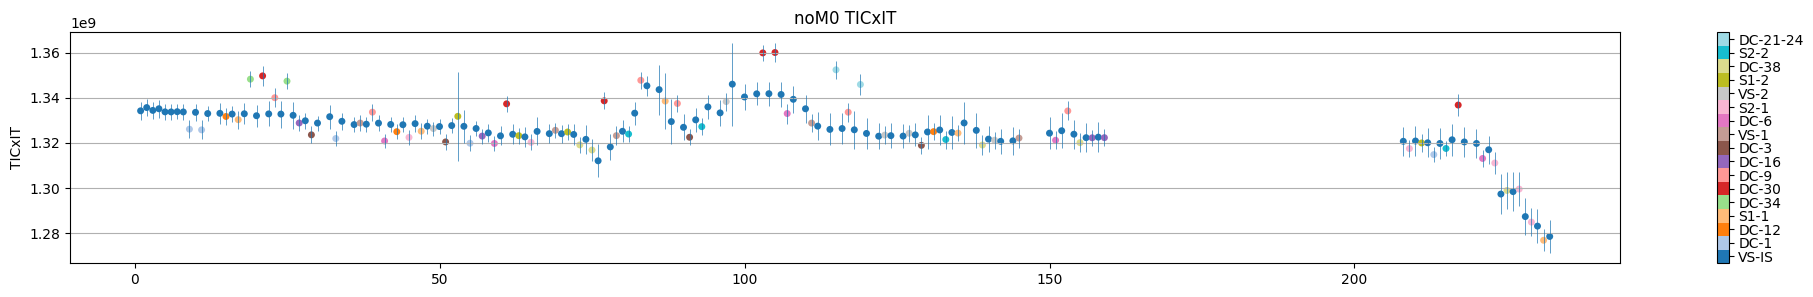

In [22]:
# plot after filtering
# colour mapping
categories = summ_filt['sample_name']
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])
discrete_cmap = plt.colormaps.get_cmap('tab20')

# TICxIT plot
fig,ax=plt.subplots(figsize=[25,3])
scatter = ax.scatter(x=summ_filt['sample_ID'],  # x-values
                  y=summ_filt['TICxIT_av'],  # y-values
                  c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
ax.errorbar(x=summ_filt['sample_ID'], y=summ_filt['TICxIT_av'], yerr=summ_filt['TICxIT_std'], lw=0.5,ls='none',fmt='none')
cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
cbar.set_ticklabels(categories.unique())
ax.grid(True, axis='y')
ax.set_ylabel('TICxIT')
ax.set_title(exp+' TICxIT')

## 3. Calculation of delta values
### a. Bracketing
Uses brackting formula: $\delta = \frac{2R_i}{R_{i-1}+R_{i+1}}-1$ to calculate internal deltas for each isotopologue for every sample which is surrounded by internal standards.  
- Saves internal deltas as 'internal_deltas_YYYY-MM-DD.csv'.  
- Saves summary as 'internal_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


<>:110: SyntaxWarning: invalid escape sequence '\d'
<>:111: SyntaxWarning: invalid escape sequence '\d'
<>:110: SyntaxWarning: invalid escape sequence '\d'
<>:111: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\3913144597.py:110: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\3913144597.py:111: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_title('Internal $\delta' + iso +'$ relative to '+int_std+' base-peak (not blank-corrected)')


Internal standard manually selected: VS-IS
Bracketed internal delta values relative to basepeak saved as results_2025-02-08\internal_deltas_2025-02-08.csv
Summarised ouptut saved as results_2025-02-08\internal_deltas_summary_2025-02-08.csv


sample_type position basepeak          rel_to scans_sample  \
sample_name                                                              
DC-1            Unknown     B:D7      34S  VS-IS 34S peak         1485   
DC-12           Unknown     B:E2      34S  VS-IS 34S peak          897   
DC-16           Unknown     B:E3      34S  VS-IS 34S peak         1212   
DC-21-24        Unknown     B:E5      34S  VS-IS 34S peak          574   
DC-3            Unknown     B:D8      34S  VS-IS 34S peak         1150   
DC-30           Unknown     B:E7      34S  VS-IS 34S peak         1723   
DC-34           Unknown     B:E8      34S  VS-IS 34S peak          610   
DC-38           Unknown     B:E9      34S  VS-IS 34S peak         1253   
DC-6            Unknown     B:D9      34S  VS-IS 34S peak         1462   
DC-9            Unknown     B:E1      34S  VS-IS 34S peak         1769   
S1-1            Unknown     B:D1      34S  VS-IS 34S peak         1433   
S1-2            Unknown     B:D4      34S  VS-IS 34S peak         1154   
S2-1            Unknown     B:D2      34S  VS-IS 34S peak         1706   
S2-2            Unknown     B:D5      34S  VS-IS 34S peak         1165   
VS-1            Unknown     B:D3      34S  VS-IS 34S peak         1441   
VS-2            Unknown     B:D6      34S  VS-IS 34S peak         1463   

            scans_std mean_d17O mean_d17O18O mean_d18O mean_d18O18O  ...  \
sample_name                                                          ...   
DC-1          1.4e+03       -25          -57       -35          -64  ...   
DC-12         8.7e+02       -18          -53       -21          -60  ...   
DC-16         1.1e+03       -11          -32       -14          -44  ...   
DC-21-24      5.7e+02      -5.7          -49       -12          -24  ...   
DC-3          1.1e+03       -23          -49       -32          -64  ...   
DC-30         1.7e+03      -8.8          -54       -17          -32  ...   
DC-34         5.9e+02       -13          -51       -20          -41  ...   
DC-38         1.4e+03       -15          -45       -23          -50  ...   
DC-6          1.4e+03       -24          -45       -33          -62  ...   
DC-9          1.7e+03       -20          -61       -28          -55  ...   
S1-1          1.4e+03      -7.1          -22      -7.5          -28  ...   
S1-2            1e+03      -8.1          -29       -10          -27  ...   
S2-1          1.6e+03       -15          -25       -17          -30  ...   
S2-2          1.1e+03       -16          -39       -16          -33  ...   
VS-1          1.4e+03         6          2.4       9.6           -4  ...   
VS-2          1.4e+03       2.6         0.91       8.2         -7.7  ...   

            err_d34S17O err_d36S TIC_sample TIC_std TIC_RSE_sample  \
sample_name                                                          
DC-1                  1     0.85    2.6e+07 5.7e+07           0.02   
DC-12               1.4        1    2.2e+07 5.4e+07          0.019   
DC-16               1.3      0.7    2.1e+07 4.9e+07           0.02   
DC-21-24            1.6        2    2.6e+07 4.5e+07          0.023   
DC-3                1.1      1.4    2.8e+07 5.2e+07           0.02   
DC-30              0.89      1.1      3e+07 4.8e+07          0.021   
DC-34               1.5     0.93    2.2e+07 5.8e+07          0.017   
DC-38               1.2      0.8      2e+07   5e+07          0.026   
DC-6                  1      1.2    3.2e+07 4.7e+07           0.02   
DC-9                  1     0.89    2.9e+07 5.3e+07          0.019   
S1-1               0.95     0.72    2.6e+07 5.6e+07           0.03   
S1-2                1.3     0.69    2.8e+07 5.2e+07           0.06   
S2-1                  1      1.5    2.5e+07 4.6e+07          0.023   
S2-2                1.1      1.3    3.1e+07 4.5e+07          0.021   
VS-1                1.4      0.6    2.8e+07 4.8e+07          0.021   
VS-2                  1     0.77    3.1e+07 4.8e+07          0.021   

             TIC_RSE_std  TICxIT_sample  TICxIT_s

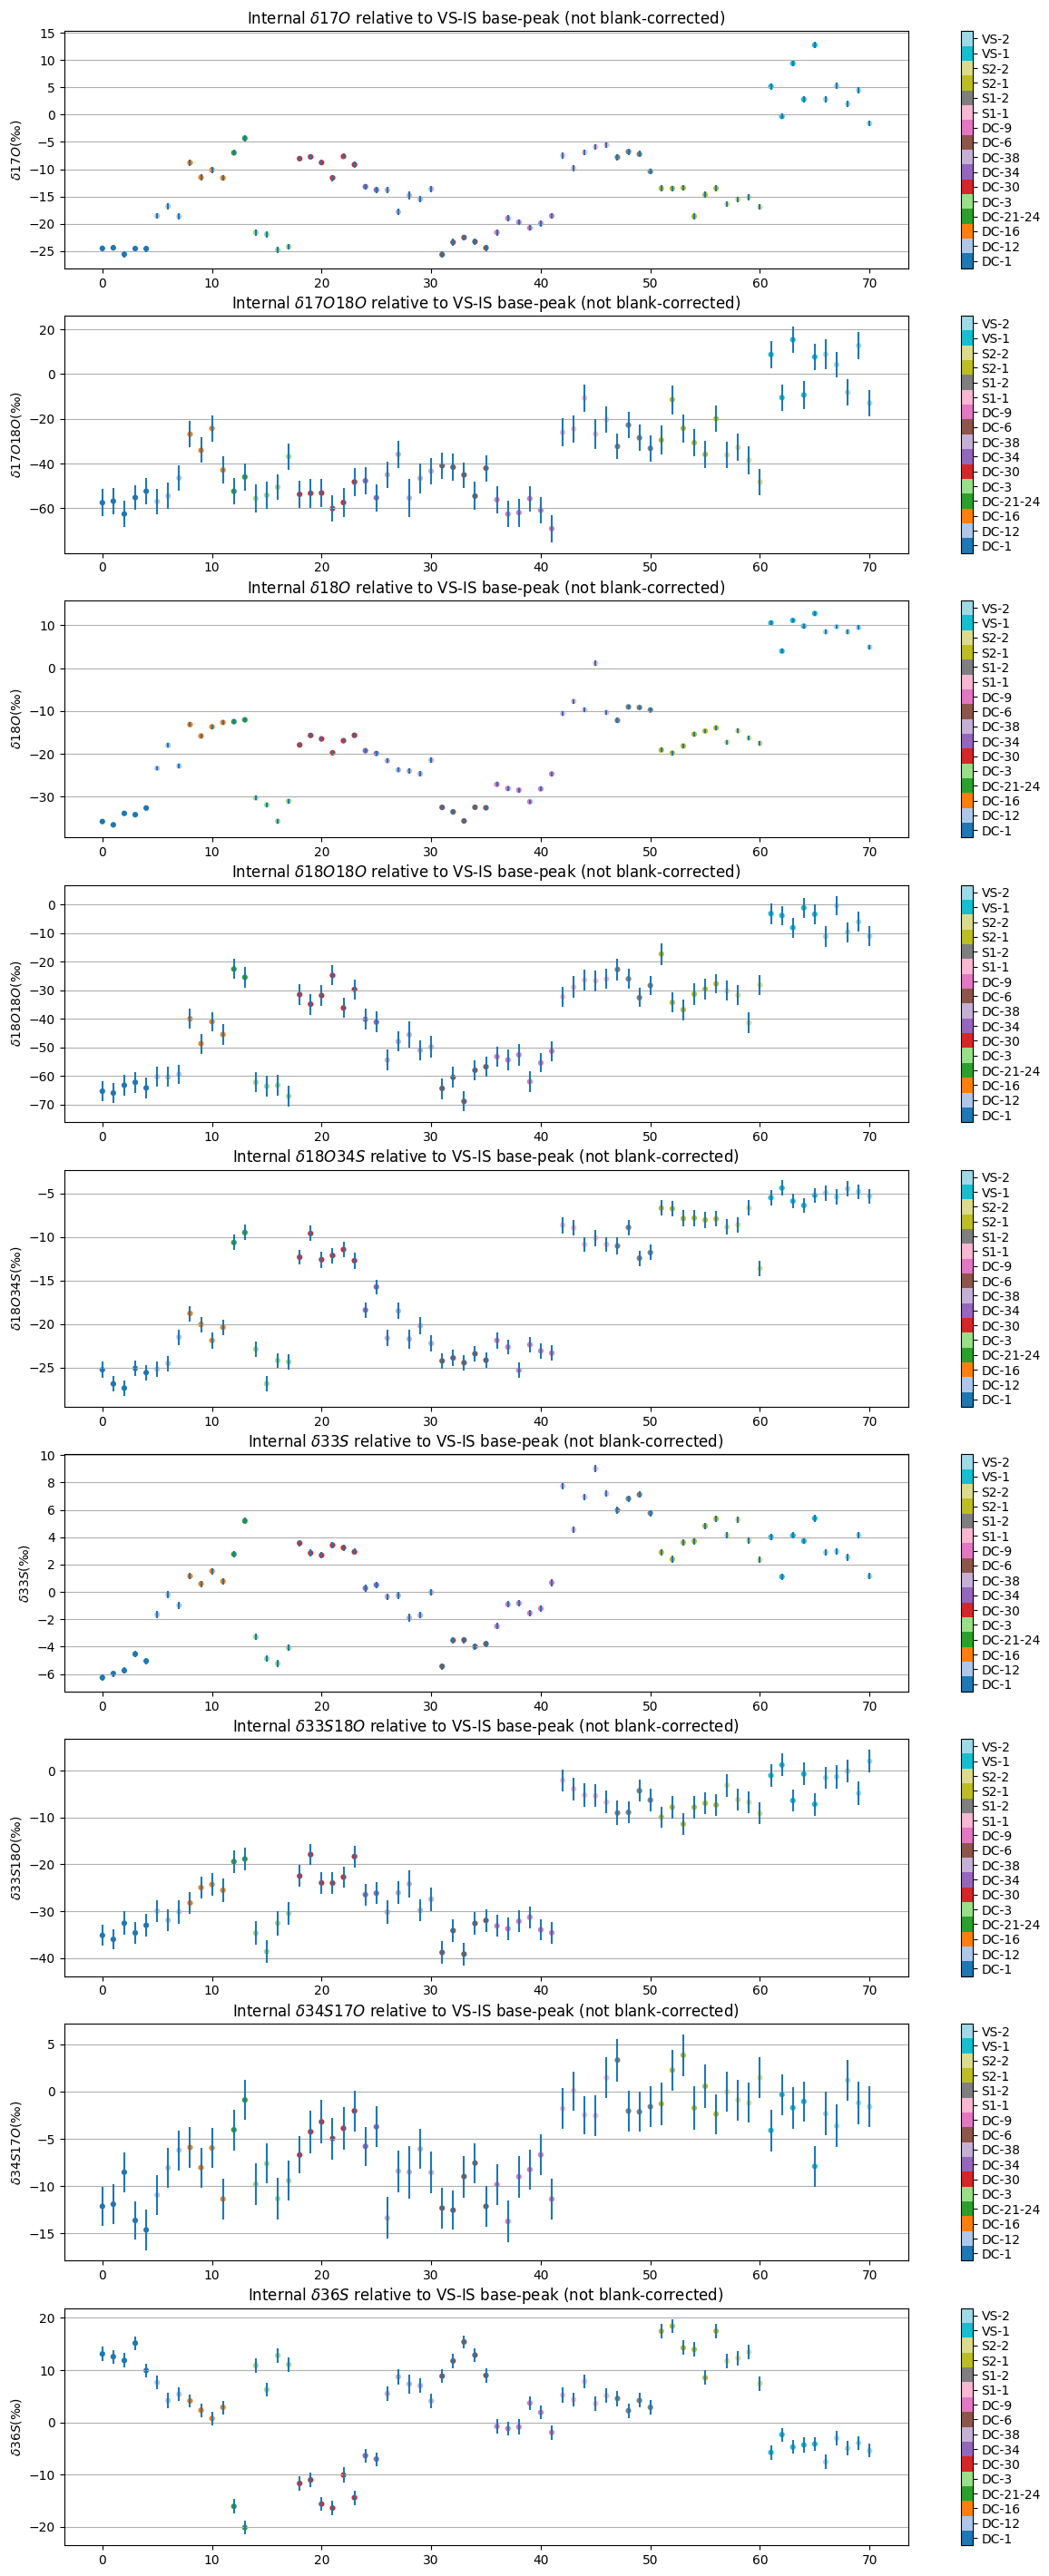

In [23]:
# identify internal standard
if len(summ_filt[summ_filt['sample_type']=='Internal standard']['sample_name'].unique())==1:
    int_std = summ_filt[summ_filt['sample_type']=='Internal standard']['sample_name'].iloc[0]
    print('Identified internal standard',int_std)
else:
    int_std = 'VS-IS'
    print("Internal standard manually selected:",int_std)
    

# identify isotopologs
isotopologues = [col.split('_')[1] for col in summ_filt.columns if col.split('_')[0]=='ratio']
    
# identify sample injections
samples = summ_filt[summ_filt['sample_name'] != int_std]
samples_delta = pd.DataFrame(columns=['sample_type','sample_name','position','blockname','basepeak']+['d'+iso for iso in isotopologues]+['err_d'+iso for iso in isotopologues]+['rel_to','TIC_sample','scans_sample','scans_std','notes'],index = samples.index)
samples_delta.loc[:,['sample_ID','sample_type','sample_name','position','blockname','basepeak','notes']]=samples.loc[:,['sample_ID','sample_type','sample_name','position','blockname','basepeak','notes']]


# bracketing
for i in samples.index:
    if i-1 in summ_filt.index and i+1 in summ_filt.index:
        if summ_filt.loc[i-1,'sample_name']== int_std and summ_filt.loc[i+1,'sample_name']==int_std:
            # calc delta
            R_i = summ_filt.loc[i,['ratio_'+iso for iso in isotopologues]]
            R_minus = summ_filt.loc[i-1,['ratio_'+iso for iso in isotopologues]]
            R_plus = summ_filt.loc[i+1,['ratio_'+iso for iso in isotopologues]]
            deltas = 2*R_i/(R_minus+R_plus)-1
            samples_delta.loc[i,['d'+iso for iso in isotopologues]] = deltas.tolist()
            # calc error
            e_i = summ_filt.loc[i,['sem_'+iso for iso in isotopologues]]
            e_minus = summ_filt.loc[i-1,['sem_'+iso for iso in isotopologues]]
            e_plus = summ_filt.loc[i+1,['sem_'+iso for iso in isotopologues]]
            err_d = e_i.copy()
            for sem_iso in e_i.index:
                err_d.loc[sem_iso] = ((2*e_i[sem_iso])**2 + e_minus[sem_iso]**2 + e_plus[sem_iso]**2)**0.5/(0.5*R_minus['ratio_'+sem_iso[4:]]+0.5*R_plus['ratio_'+sem_iso[4:]]+R_i['ratio_'+sem_iso[4:]])
            samples_delta.loc[i,['err_d'+iso for iso in isotopologues]] = err_d.tolist()
            
        samples_delta.loc[i,'rel_to'] = int_std+' '+samples_delta.loc[i,'basepeak']+' peak'
        samples_delta.loc[i,'TIC_sample']=summ_filt.loc[i,'TIC_av']
        samples_delta.loc[i,'TIC_std']=0.5*(summ_filt.loc[i-1,'TIC_av']+summ_filt.loc[i+1,'TIC_av'])
        samples_delta.loc[i,'TIC_RSE_sample']=summ_filt.loc[i,'TIC_rse'] 
        samples_delta.loc[i,'TIC_RSE_std']=summ_filt.loc[i-1,'TIC_rse']
        samples_delta.loc[i,'TICxIT_sample']=summ_filt.loc[i,'TICxIT_av']
        samples_delta.loc[i,'TICxIT_std']=0.5*(summ_filt.loc[i-1,'TICxIT_av']+summ_filt.loc[i+1,'TICxIT_av']) 
        samples_delta.loc[i,'scans_sample']=summ_filt.loc[i,'scans']
        samples_delta.loc[i,'scans_std']=0.5*(summ_filt.loc[i-1,'scans']+summ_filt.loc[i+1,'scans'])
        samples_delta.loc[i,'notes']=summ_filt.loc[i,'notes']
samples_delta.dropna(how='all',subset=['d'+iso for iso in isotopologues],inplace=True)
samples_delta = samples_delta.sort_values('sample_name').reset_index(drop=True)
samples_delta.reset_index(inplace=True,drop=True)

# save
samples_delta.to_csv(os.path.join(pathresults,'internal_deltas_'+current_date_string+'.csv'))
print('Bracketed internal delta values relative to basepeak saved as '+ os.path.join(pathresults,'internal_deltas_'+current_date_string+'.csv'))

# summarise internal deltas per sample/experiment combo
stats=pd.DataFrame()
stats['sample_ID']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_ID']
stats['sample_name']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_name']
stats['sample_type']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['sample_type']
stats['position']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['position']
stats['basepeak']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['basepeak']
stats['rel_to']=samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['rel_to']
stats['scans_sample']=samples_delta.groupby(['sample_name','basepeak']).sum().reset_index()['scans_sample']
stats['scans_std']=samples_delta.groupby(['sample_name','basepeak']).sum().reset_index()['scans_std']
# mean delta
stats[['mean_d'+iso for iso in isotopologues]]=samples_delta.groupby(['sample_name','basepeak'])[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
# sem of N injections
sem=samples_delta.groupby(['sample_name','basepeak'])[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]
# propogated error = sqrt(sum(err^2)/N))
def add_in_quadrature(errors):
    N = len(errors)
    return (np.sum(errors**2,axis=0)**0.5/N)
errprop = samples_delta.groupby(['sample_name','basepeak'])[['err_d'+iso for iso in isotopologues]].apply(add_in_quadrature).reset_index()[['err_d'+iso for iso in isotopologues]]
# select the grater error val
sem.columns = errprop.columns
stats[['err_d'+iso for iso in isotopologues]] = np.fmax(errprop,sem)

stats['TIC_sample'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_sample'].mean().reset_index()['TIC_sample']
stats['TIC_std'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_std'].mean().reset_index()['TIC_std']
stats['TIC_RSE_sample'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_RSE_sample'].mean().reset_index()['TIC_RSE_sample']
stats['TIC_RSE_std'] = samples_delta.groupby(['sample_name','basepeak'])['TIC_RSE_std'].mean().reset_index()['TIC_RSE_std']
stats['TICxIT_sample'] = samples_delta.groupby(['sample_name','basepeak'])['TICxIT_sample'].mean().reset_index()['TICxIT_sample']
stats['TICxIT_std'] = samples_delta.groupby(['sample_name','basepeak'])['TICxIT_std'].mean().reset_index()['TICxIT_std']
stats['notes'] = samples_delta.groupby(['sample_name','basepeak']).first().reset_index()['notes']
# sort, put sample name as index
stats = stats.sort_values('sample_name').reset_index(drop=True)
stats['order']=stats.index
stats.index=stats['sample_name']
stats.drop(['sample_name','sample_ID'],axis=1,inplace=True)

# plot
if True:
    fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

    categories = samples_delta['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])

    for i,iso in enumerate(isotopologues):
        scatter = ax[i].scatter(samples_delta.index, samples_delta['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
        ax[i].errorbar(samples_delta.index, samples_delta['d'+iso]*1000, yerr=samples_delta['err_d'+iso]*1000, fmt='none')
        cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories)) + 1) - 0.5)
        cbar.set_ticklabels(categories.unique())
        ax[i].grid(True, axis='y')
        ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
        ax[i].set_title('Internal $\delta' + iso +'$ relative to '+int_std+' base-peak (not blank-corrected)')
        # ax[i].set_xticks([])

        
# save
stats.to_csv(os.path.join(pathresults,'internal_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(pathresults,'internal_deltas_summary_'+current_date_string+'.csv'))


# function to multiply only deltas by 1e3
def  multiply_dcols(df):
    new_df = df.copy()
    for col in new_df.columns:
        if col.startswith(('mean_d','err_d')):
            new_df.loc[:,col]=new_df.loc[:,col]*1e3
    return new_df
# display
multiply_dcols(stats).head(20)

### b. Conversion of internal deltas to international scale based on values of internal standard
Reference delta values of internal standard are taken from the reference data (inputs at top of script).  

Saves external deltas:
- Saves external deltas as 'external_deltas_YYYY-MM-DD.csv'.
- Saves summary as 'external_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:66: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\3364004852.py:65: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\3364004852.py:66: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_title('External $\delta' + iso +'$')


Imported reference data for internal standard VS from references_sulphate.xlsx
mean_d33S          0
mean_d34S          0
mean_d36S          0
mean_d17O          0
mean_d18O          0
mean_d33S/34S      0
mean_d17O/34S      0
mean_d18O/34S      0
mean_d36S/34S      0
mean_d34S18O/34S   0
mean_d33S18O/34S   0
mean_d17O18O/34S   0
mean_d34S17O/34S   0
mean_d18O18O/34S   0
Name: VS, dtype: float64
Changed reference of internal deltas to international reference scale. 
Summarised output saved as results_2025-02-08\external_deltas_2025-02-08.csv


sample_type position basepeak                            rel_to  \
sample_name                                                                   
DC-1            Unknown     B:D7      34S  international reference 34S peak   
DC-12           Unknown     B:E2      34S  international reference 34S peak   
DC-16           Unknown     B:E3      34S  international reference 34S peak   
DC-21-24        Unknown     B:E5      34S  international reference 34S peak   
DC-3            Unknown     B:D8      34S  international reference 34S peak   
DC-30           Unknown     B:E7      34S  international reference 34S peak   
DC-34           Unknown     B:E8      34S  international reference 34S peak   
DC-38           Unknown     B:E9      34S  international reference 34S peak   
DC-6            Unknown     B:D9      34S  international reference 34S peak   
DC-9            Unknown     B:E1      34S  international reference 34S peak   
S1-1            Unknown     B:D1      34S  international reference 34S peak   
S1-2            Unknown     B:D4      34S  international reference 34S peak   
S2-1            Unknown     B:D2      34S  international reference 34S peak   
S2-2            Unknown     B:D5      34S  international reference 34S peak   
VS-1            Unknown     B:D3      34S  international reference 34S peak   
VS-2            Unknown     B:D6      34S  international reference 34S peak   

            scans_sample scans_std mean_d17O mean_d17O18O mean_d18O  \
sample_name                                                           
DC-1                1485   1.4e+03       -25          -57       -35   
DC-12                897   8.7e+02       -18          -53       -21   
DC-16               1212   1.1e+03       -11          -32       -14   
DC-21-24             574   5.7e+02      -5.7          -49       -12   
DC-3                1150   1.1e+03       -23          -49       -32   
DC-30               1723   1.7e+03      -8.8          -54       -17   
DC-34                610   5.9e+02       -13          -51       -20   
DC-38               1253   1.4e+03       -15          -45       -23   
DC-6                1462   1.4e+03       -24          -45       -33   
DC-9                1769   1.7e+03       -20          -61       -28   
S1-1                1433   1.4e+03      -7.1          -22      -7.5   
S1-2                1154     1e+03      -8.1          -29       -10   
S2-1                1706   1.6e+03       -15          -25       -17   
S2-2                1165   1.1e+03       -16          -39       -16   
VS-1                1441   1.4e+03         6          2.4       9.6   
VS-2                1463   1.4e+03       2.6         0.91       8.2   

            mean_d18O18O  ... err_d34S17O err_d36S TIC_sample TIC_std  \
sample_name               ...                                           
DC-1                 -64  ...           1     0.85    2.6e+07 5.7e+07   
DC-12                -60  ...         1.4        1    2.2e+07 5.4e+07   
DC-16                -44  ...         1.3      0.7    2.1e+07 4.9e+07   
DC-21-24             -24  ...         1.6        2    2.6e+07 4.5e+07   
DC-3                 -64  ...         1.1      1.4    2.8e+07 5.2e+07   
DC-30                -32  ...        0.89      1.1      3e+07 4.8e+07   
DC-34                -41  ...         1.5     0.93    2.2e+07 5.8e+07   
DC-38                -50  ...         1.2      0.8      2e+07   5e+07   
DC-6                 -62  ...           1      1.2    3.2e+07 4.7e+07   
DC-9                 -55  ...           1     0.89    2.9e+07 5.3e+07   
S1-1                 -28  ...        0.95     0.72    2.6e+07 5.6e+07   
S1-2                 -27  ...         1.3     0.69    2.8e+07 5.2e+07   
S2-1                 -30  ...           1      1.5    2.5e+07 4.6e+07   
S2-2                 -33  ...         1.1      1.3    3.1e+07 4.5e+07   
VS-1                  -4  ...         1.4      0.6    2.8e+07 4.8e+07   
VS-2                -7.7  ...           1     0.77    3.1e+07 4.8e+07

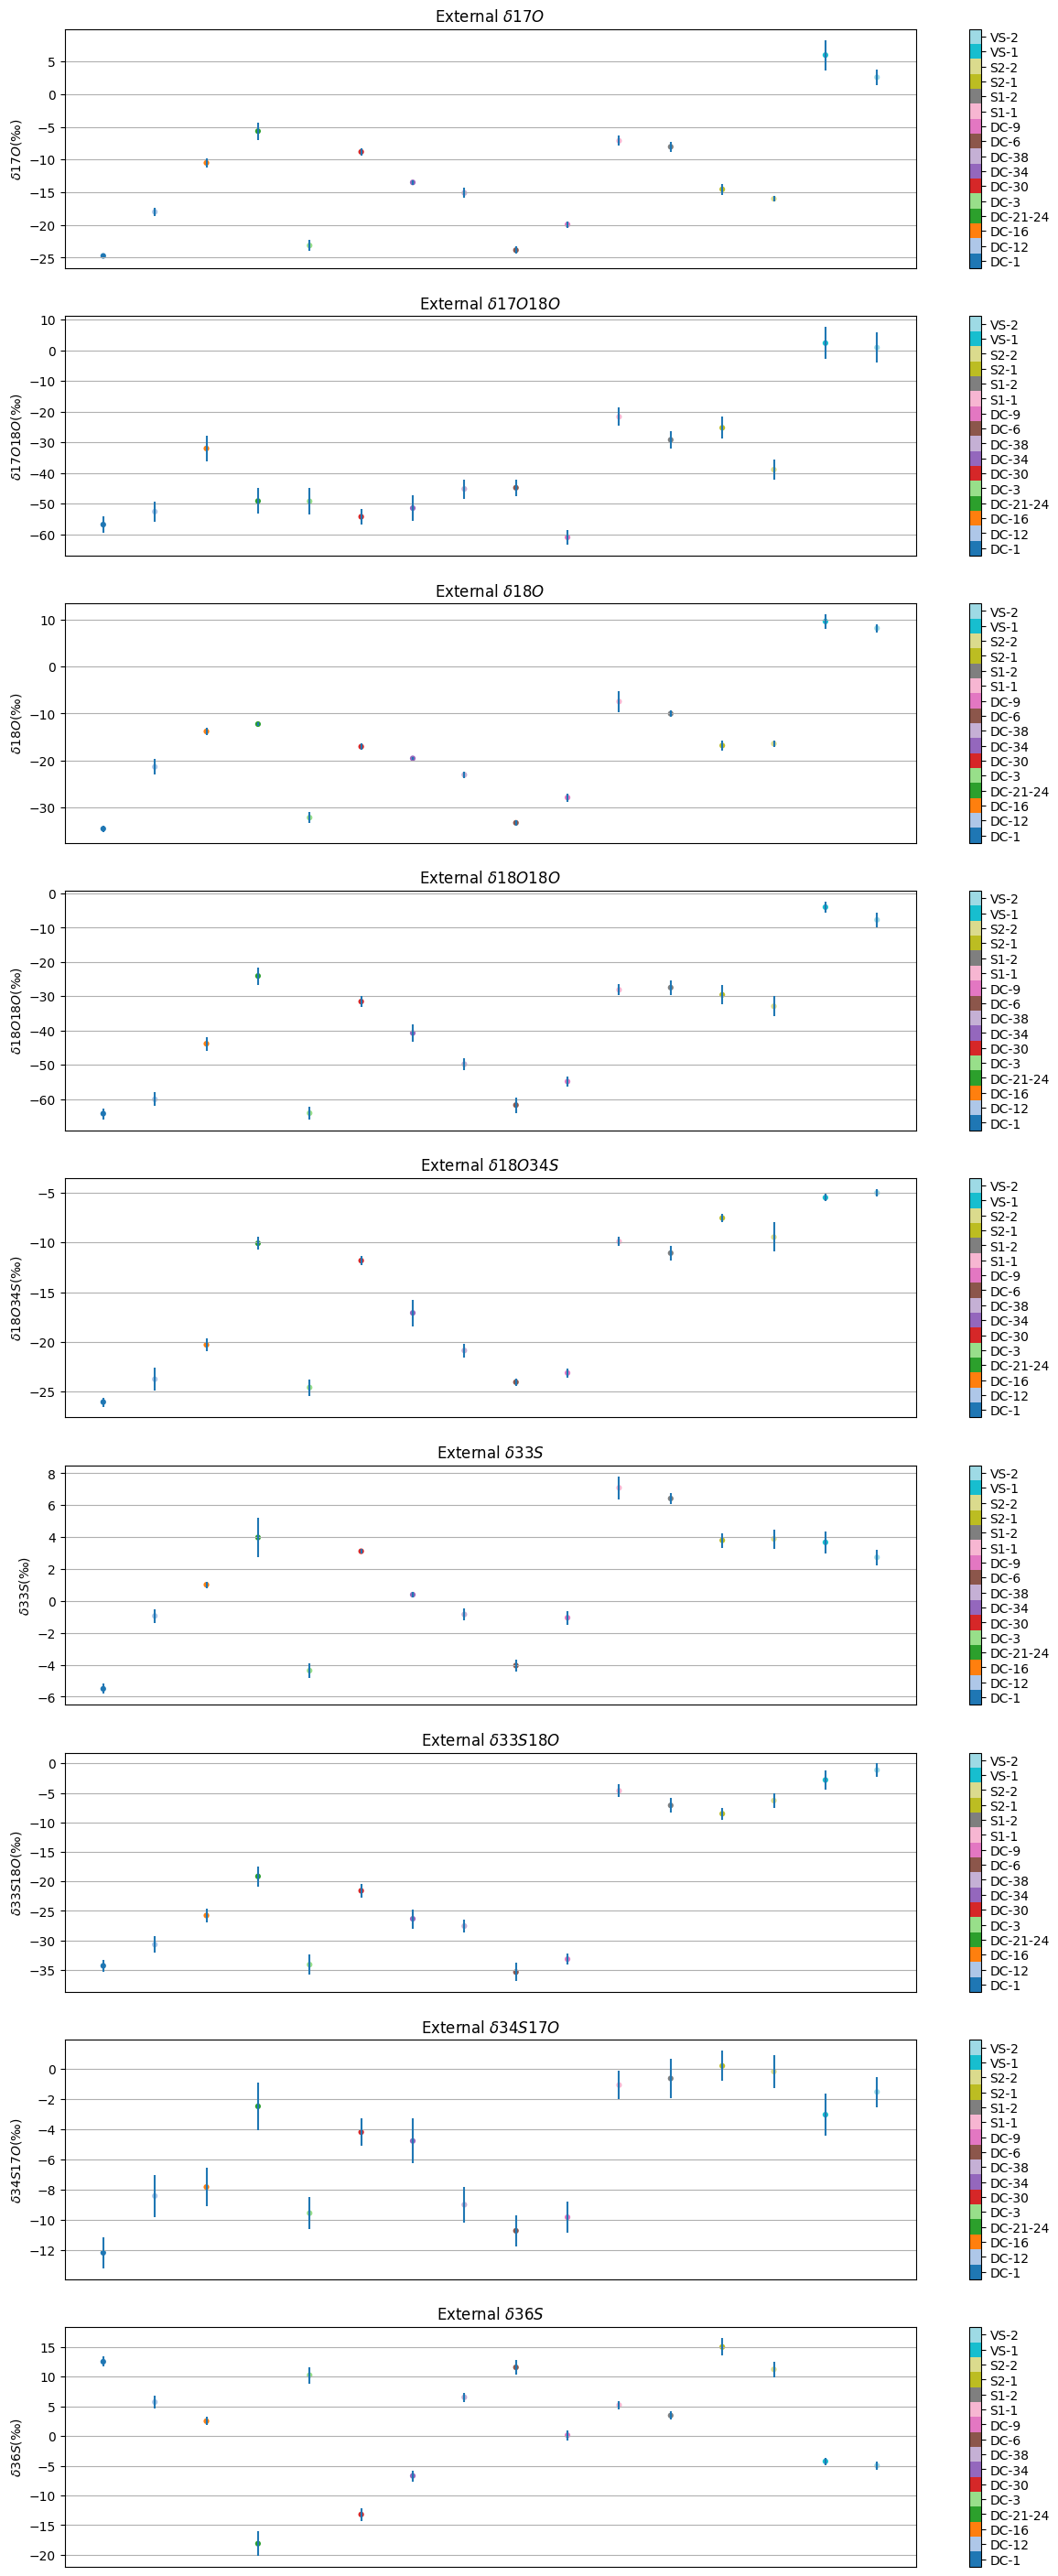

In [24]:
df = stats.copy()

# Import reference data for internal standard

references = pd.read_excel(ref_filename, index_col='sample_name')

internal_std_short = int_std.split('-')[0]
refs_stats = references.loc[internal_std_short]
refs_stats = refs_stats*1e-3

# display
print('Imported reference data for internal standard '+internal_std_short+' from '+ ref_filename)
print(refs_stats[[iso for iso in refs_stats.index if iso.startswith('mean_d')]])

# change reference to international scale based on internal standard supposed values
df_international_scale=df.copy()
for sample in df.index:
    # identify isotopologues
    isotopolog_cols = [iso for iso in df.columns if iso.startswith('mean')]
    # identify basepeak
    bp = df.loc[sample,'basepeak']
    # identify and rename the internal standard used
    int_std_name = df.loc[sample,'rel_to']
    int_std_name = int_std_name.split('-')[0]
    # select internal standard delta vals
    if int_std_name == refs_stats.name:
        if bp=='M0':
            int_std_cols = [iso for iso in isotopolog_cols  if iso in refs_stats.index ]
        elif bp in ['15N','18O','34S']:
            int_std_cols = [iso+'/'+bp for iso in isotopolog_cols  if iso+'/'+bp in refs_stats.index ]
        else:
            print('Basepeak not identified for',sample)
        int_std_deltas = refs_stats.loc[int_std_cols]
         # correct using change of reference formula
        for col in int_std_deltas.index:
            d1 = df.loc[sample, col.split('/')[0]] # internal delta for all samples
            d2 = int_std_deltas[col]  #delta of standard
            d_corr = d1 + d2 + d1*d2
            df_international_scale.loc[sample, col.split('/')[0]] = d_corr
        df_international_scale.loc[sample,'rel_to'] = 'international reference'+' '+df.loc[sample,'basepeak']+' peak'
    else:
        print("Couldn't find standard: "+ int_std_name+ ' in reference data. Using internal deltas for '+ str(df.loc[i,'sample_name']))

# save deltas as csv
df_international_scale.to_csv(os.path.join(pathresults,'external_deltas_'+current_date_string+'.csv'))
print('Changed reference of internal deltas to international reference scale. \nSummarised output saved as '+os.path.join(pathresults,'external_deltas_'+current_date_string+'.csv'))

# plot
fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

categories = df_international_scale.index
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

for i,iso in enumerate(isotopologues):
    scatter = ax[i].scatter(df_international_scale.index, df_international_scale['mean_d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
    ax[i].errorbar(df_international_scale.index, df_international_scale['mean_d'+iso]*1000, yerr=df_international_scale['err_d'+iso]*1000, fmt='none')
    cbar = plt.colorbar(scatter, ticks=pd.Series(numeric_categories).unique(), boundaries=np.arange(len(pd.Series(numeric_categories).unique() )+ 1) - 0.5)
    cbar.set_ticklabels(pd.Series(categories).unique())
    ax[i].grid(True, axis='y')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('External $\delta' + iso +'$')
    ax[i].set_xticks([])
    

# display
multiply_dcols(df_international_scale).head(20)

## Plot final results

<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\4293042951.py:27: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\4293042951.py:28: SyntaxWarning: invalid escape sequence '\d'
  ax[i].set_title('$\delta' + iso +'$')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\4293042951.py:39: SyntaxWarning: invalid escape sequence '\D'
  ax[i].set_ylabel('$\Delta^{17}O$(‰)')
C:\Users\Thermo\AppData\Local\Temp\ipykernel_27628\4293042951.py:40: SyntaxWarning: invalid escape sequence '\D'
  ax[i].set_ti

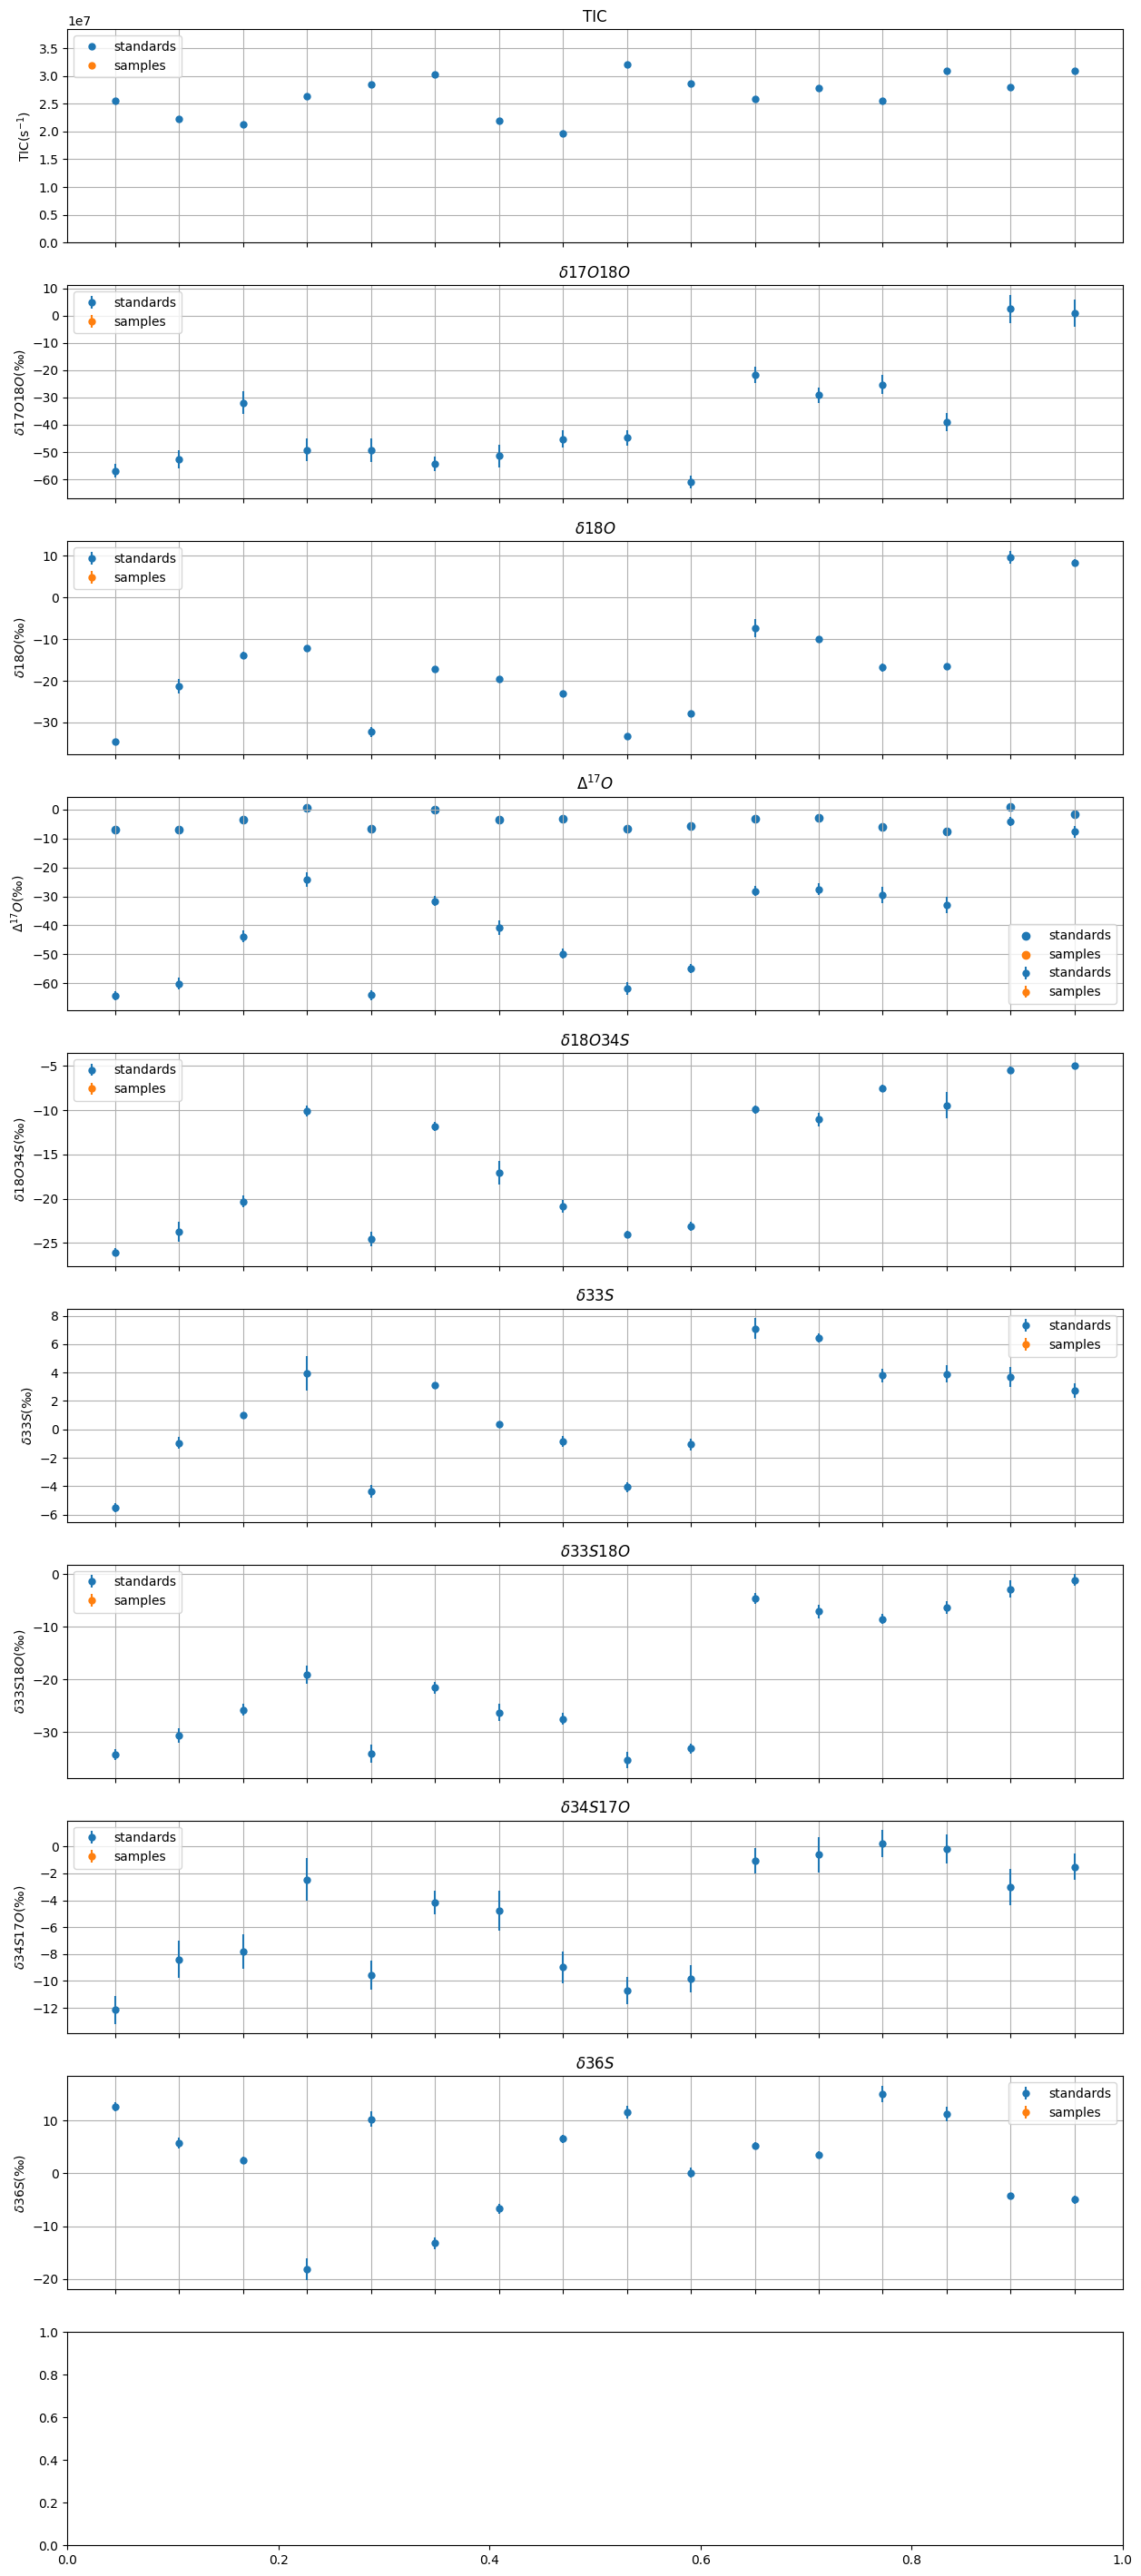

In [25]:
isotopologues_wo17 = [iso for iso in isotopologues if iso!='17O']

data = df_international_scale.copy()
data_spl = data.drop(index=[name for name in data.index if not name.startswith('C')])

fig,ax = plt.subplots(len(isotopologues_wo17)+2, figsize=[15,4*(len(isotopologues_wo17)+1)])

i=0
scatter = ax[i].errorbar([name for name in data.index], data['TIC_sample'],
                        linestyle='none',marker='o',ms=5,label='standards')
scatter = ax[i].errorbar([name for name in data_spl.index], data_spl['TIC_sample'],
                        linestyle='none',marker='o',ms=5,label='samples')
ax[i].grid(True, axis='both')
ax[i].set_ylabel('TIC(s$^{-1}$)')
ax[i].set_title('TIC')
ax[i].set_xticklabels([])
ax[i].set_ylim([0,1.2*max( data['TIC_sample'])])
ax[i].legend()

for ii,iso in enumerate(isotopologues_wo17):
    i=ii+1
    scatter = ax[i].errorbar([name for name in data.index], data['mean_d'+iso]*1000, yerr=data['err_d'+iso]*1000,
                            linestyle='none',marker='o',ms=5,label='standards')
    scatter = ax[i].errorbar([name for name in data_spl.index], data_spl['mean_d'+iso]*1000, yerr=data_spl['err_d'+iso]*1000,
                            linestyle='none',marker='o',ms=5,label='samples')
    ax[i].grid(True, axis='both')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('$\delta' + iso +'$')
    ax[i].set_xticklabels([])
    ax[i].legend()
    
i=3
if '17O' in isotopologues and '18O' in isotopologues:
    D17 = data['mean_d17O']*1000 - 0.515* data['mean_d18O']*1000
    scatter = ax[i].scatter([name for name in data.index], D17,label='standards')
    D17 = data_spl['mean_d17O']*1000 - 0.515* data_spl['mean_d18O']*1000
    scatter = ax[i].scatter([name for name in data_spl.index], D17,label='samples')
    ax[i].grid(True, axis='both')
    ax[i].set_ylabel('$\Delta^{17}O$(‰)')
    ax[i].set_title('$\Delta^{17}O$')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=90)
    ax[i].legend()

## 6. Save data to excel file

Saves results to the file specified in inputs, with each as a seperate sheet:
- Block average ratios, start/end times, #scans, median scan duration, average and std TIC and TICxIT
- Bracketed deltas before any correction
- Deltas after M0 correction
- Deltas after correction to international scale using value of internal standard (not calibrated)
- Summaries of mean and uncertainty of all bracketed deltas  

Note: saved delta values are not in permil


In [26]:
to_save = {'Block averages':summ,
           'Bracketed deltas':samples_delta,
           'Bracketed deltas summary':stats,
           'Referenced deltas summary':df_international_scale}

for sheet_name, df in to_save.items():
    # Check if the file exists
    if not os.path.exists(os.path.join(output_file)):
        # If the file doesn't exist, create a new ExcelWriter object without mode='a'
        with pd.ExcelWriter(os.path.join(output_file), engine='openpyxl') as writer:
            # Write the DataFrame to a new sheet with the specified sheet name
            df.to_excel(writer, sheet_name=sheet_name, index=True)
            print('Excel file created:',os.path.join(output_file),'\nNew sheet added to',output_file,':',sheet_name)
    else:
        # If the file exists, create an ExcelWriter object with mode='a' to append to the existing file
        with pd.ExcelWriter(os.path.join(output_file), engine='openpyxl', mode='a',if_sheet_exists='replace') as writer:
            # Write the DataFrame to a new sheet with the specified sheet name
            df.to_excel(writer, sheet_name=sheet_name, index=True)
            print('New sheet added to',output_file,':',sheet_name)

Excel file created: results_2025-02-08.xlsx 
New sheet added to results_2025-02-08.xlsx : Block averages
New sheet added to results_2025-02-08.xlsx : Bracketed deltas
New sheet added to results_2025-02-08.xlsx : Bracketed deltas summary
New sheet added to results_2025-02-08.xlsx : Referenced deltas summary
